# Mijnarends et al. (2022): Finding accreted stars in the Milky Way: clues from NIHAO simulations

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import glob
import scipy
import astropy.io.fits as pyfits
# import corner
import os
import pandas
from astropy.table import Table, hstack, vstack, join
from astropy.io import fits
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon

# Part 1: Prepare Data

## 1a) Read in the data from GALAH+ DR3.  
We already have cross-matched the main catalog and the value-added catalogs via sobject_id.  
The catalog data is provided at https://datacentral.org.au/teamdata/GALAH/public/GALAH_DR3/   
The analysis is described by Buder et al. (2022): https://ui.adsabs.harvard.edu/abs/2021MNRAS.506..150B.  

In [6]:
try:
     obs = Table.read('GALAH_DR3_all_joined_v2.fits')
except:
    ### I can't access the complete, joined file
    file1 = 'GALAH_DR3_main_allstar_v2.fits'
    data1 = pyfits.getdata(file1)

    filename = 'GALAH_DR3_main_allstar_v2.fits'
    fits_file = fits.open(filename)
    allstar = fits_file[1].data
    fits_file.close()

    filename = 'GALAH_DR3_VAC_ages_v2.fits'
    fits_file = fits.open(filename)
    ages = fits_file[1].data
    fits_file.close()

    filename = 'GALAH_DR3_VAC_dynamics_v2.fits'
    fits_file = fits.open(filename)
    dyn = fits_file[1].data
    fits_file.close()

    files = join(allstar, dyn, keys = 'sobject_id')

    obs = join(files, ages, keys = 'sobject_id')

In [7]:
# For the observations, we need to apply some quality checks to only continue with high-fidelity data
# By default, we choose the following:
observation_quality_check_default = (
    (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
    (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
    np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Mg']],axis=0)[0] # flags for all abundances measurements should be unflagged, here only Mg is tested
)

## 1b) Read in the simulation
The simulation is part of the NIHAO suite.  
This particular simulation can be retrieved from Tobias Buck.  
It is described in detail in Buck et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3365B

In [8]:
fits_file = fits.open('simulation_data_220118.fits')
sim = fits_file[1].data
fits_file.close()


# Part 2: Overview of the abundances in observation and simulations

The simulation traces the chemical evolution of the following elements:  
H, He, C, N, O, Ne, Mg, Al, Si, P, S, V, Cr, Mn, Fe, Co, Ba.  

Of these, the following ten are also reported by the GALAH survey:  
C, O, Mg, Al, Si, V, Cr, Mn, Co and Ba

Caption: Distribution of elemental abundances [X/Fe] versus [Fe/H] for the ten elements overlapping between GALAH and NIHAO. Observations are shown in first and third row with simulated distributions in the row next to them. Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities. For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. Dashed lines indicate Solar values.


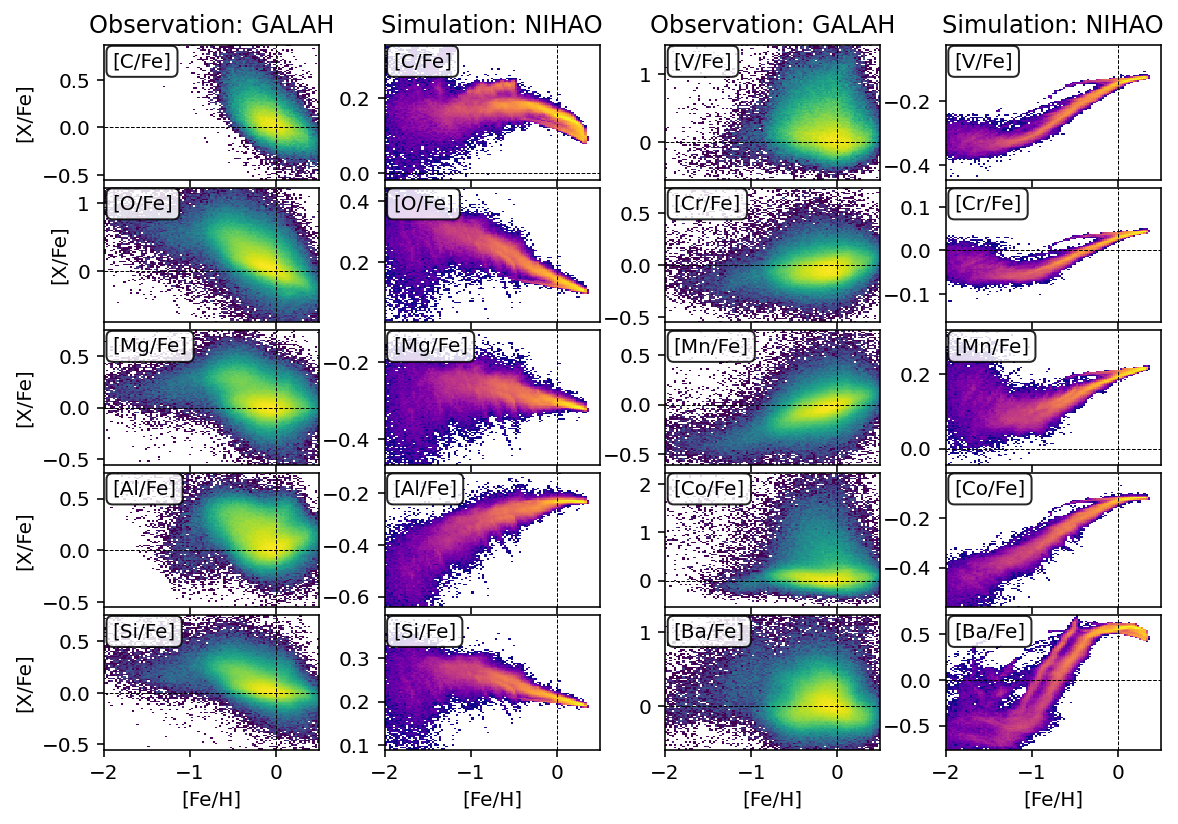

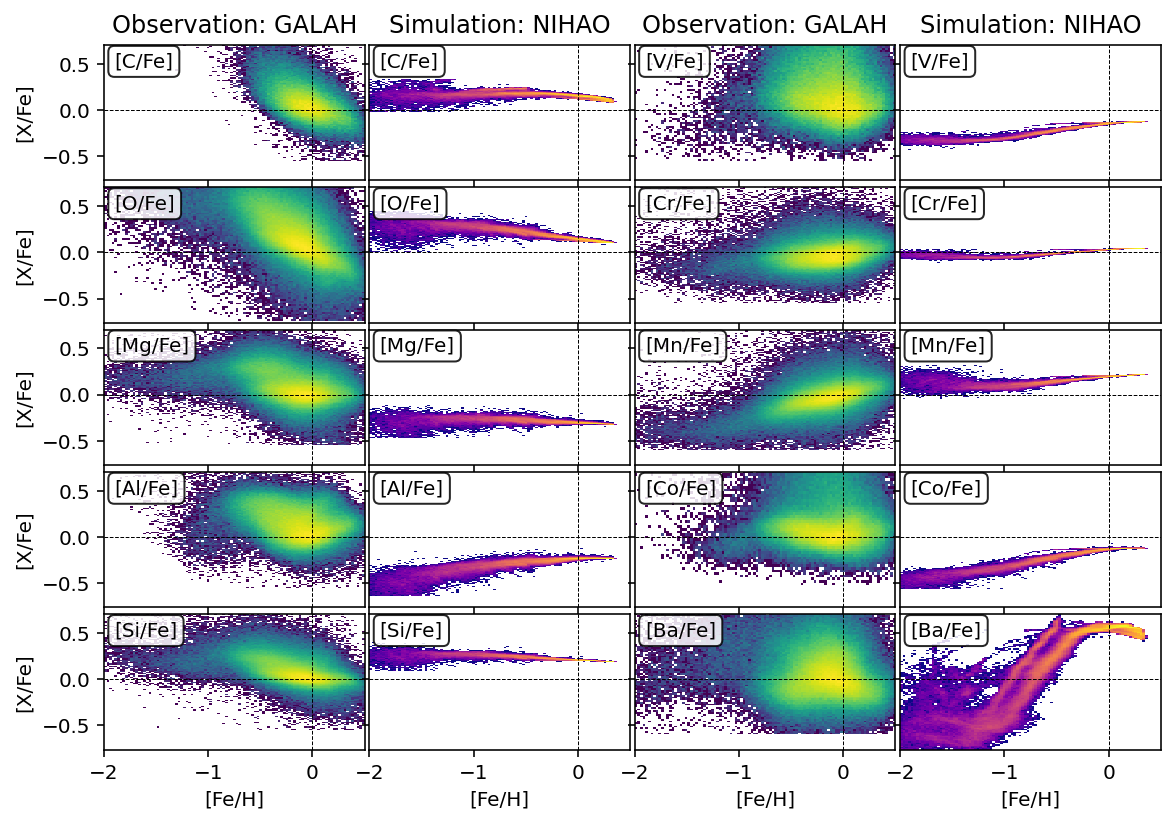

In [9]:
# Let's plot an overview of all these 10 elements:

def plot_abundance_overview_observations_simulations(sharey=False):
    """
    Distribution of elemental abundances [X/Fe] versus [Fe/H] 
    for the ten elements overlapping between GALAH and NIHAO.
    
    Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities.
    For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. 
    Dashed lines indicate Solar values.
    
    INPUT:
    sharey = False/True: Shall the abundances [X/Fe] be plotted on the same y-axis range?
    
    OUTPUT:
    plt.savefig() with or without shary
    
    """

    f, gs = plt.subplots(5,4,sharex=True,sharey=sharey,figsize=(8.27, 11.69/2.))

    for element_index, element in enumerate(['C','O','Mg','Al','Si','V','Cr','Mn','Co','Ba']):

        # For better visibility, we limit ourselves to [Fe/H] > -2 in both observations and simulations
        fe_h_lower_limit = -2
        
        # Observations are shown in first and third row with simulated distributions in the row next to them. 
        if element_index <= 4:
            ax_obs = gs[element_index,0]
            ax_sim = gs[element_index,1]
        else:
            ax_obs = gs[element_index-5,2]
            ax_sim = gs[element_index-5,3]

        ######
        # Panels with observations
        ######
        
        # We apply our usual quality checks, but here for each element individually
        observation_quality_check = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) &
            (obs['flag_'+element+'_fe'] == 0) &
            (obs['fe_h'] >= fe_h_lower_limit)
        )
        # For better visibility, we adjust the y-ranges of the plots to go between the 0.5th and 99.5th percentiles and add another +- 0.1 dex (but at least -0.55 and 0.75)
        xfe_obs = obs[element+'_fe'][observation_quality_check]
        percentiles_obs = np.percentile(xfe_obs,q=[0.5,99.5])
        ax_obs.hist2d(
            obs['fe_h'][observation_quality_check],
            obs[element+'_fe'][observation_quality_check],
            bins=(np.linspace(fe_h_lower_limit,0.5,100),np.linspace(np.min([-0.55,percentiles_obs[0]-0.1]),np.max([0.75,percentiles_obs[-1]+0.1]),100)),
            cmin = 1,
            norm = LogNorm()
        )
        
        ######
        # Panels with simulations
        ######
        
        simulation_hack = (
            (sim['Fe_H'] > fe_h_lower_limit) # This is just to make sure that the plot ranges do not explode...
        )
        # For better visibility, we adjust the y-ranges of the plots to go between the 0.5th and 99.5th percentiles and add another +- 0.1 dex
        sim_xfe = sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack]
        percentiles_sim = np.percentile(sim_xfe,q=[0.5,99.5])
        
        ax_sim.hist2d(
            sim['Fe_H'][simulation_hack],
            sim[element+'_H'][simulation_hack] - sim['Fe_H'][simulation_hack],
            bins=(np.linspace(fe_h_lower_limit,0.5,100),np.linspace(percentiles_sim[0]-0.1,percentiles_sim[-1]+0.1,100)),
            cmin = 1,
            norm = LogNorm(),
            cmap = 'plasma'
        )

        # Add text with [X/Fe]
        ax_obs.text(0.04,0.95,'['+element+'/Fe]',transform=ax_obs.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax_sim.text(0.04,0.95,'['+element+'/Fe]',transform=ax_sim.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

        # Add Solar value lines at (0,0)
        ax_obs.axhline(0,lw=0.5,ls='dashed',c='k')
        ax_sim.axhline(0,lw=0.5,ls='dashed',c='k')
        ax_obs.axvline(0,lw=0.5,ls='dashed',c='k')
        ax_sim.axvline(0,lw=0.5,ls='dashed',c='k')
        
        # Add titles and x-/y-labels
        if element_index in [0,5]:
            ax_obs.set_title('Observation: GALAH')
            ax_sim.set_title('Simulation: NIHAO')
        if element_index in [4,9]:
            ax_obs.set_xlabel('[Fe/H]')
            ax_sim.set_xlabel('[Fe/H]')
        if element_index <= 4:        
            ax_obs.set_ylabel('[X/Fe]')
   
    plt.tight_layout(h_pad=0,w_pad=-0.5)
#     if sharey:
#         plt.savefig('figures/Overview_FeH_XFe_Obs_Sim_sharey.png',bbox_inches='tight',dpi=200)
#     else:
#         plt.savefig('figures/Overview_FeH_XFe_Obs_Sim.png',bbox_inches='tight',dpi=200)

plot_abundance_overview_observations_simulations(sharey=False)
plot_abundance_overview_observations_simulations(sharey=True)

print('Caption: Distribution of elemental abundances [X/Fe] versus [Fe/H] for the ten elements overlapping between GALAH and NIHAO. Observations are shown in first and third row with simulated distributions in the row next to them. Color maps are showing the logarithmic density distributions with brightest colors indicating highest densities. For better visibility, plot ranges are adjusted to the data rather than to be equal among each panel. Dashed lines indicate Solar values.')

# Part 3: A closer look at the 'low-alpha halo'

This is inspired by the Nissen et al. (2010) plot finding different populations in the metal-poor low-/high-alpha halo regime

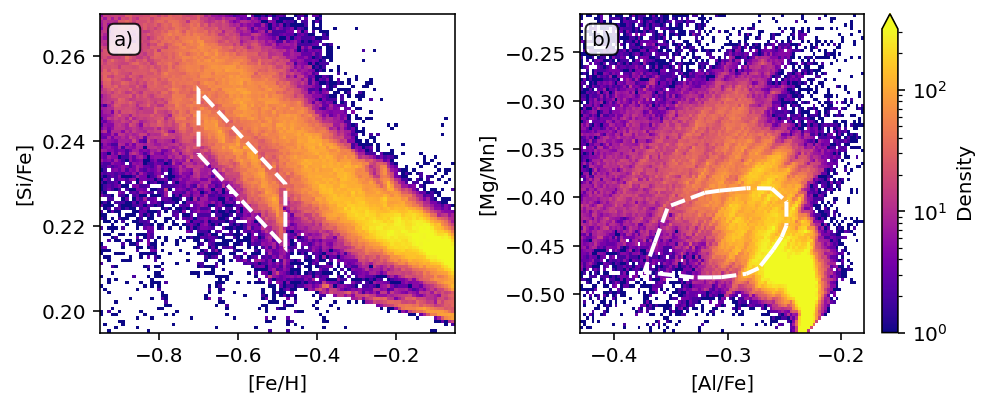

In [10]:
def plot_low_alpha_halo():

    f, gs = plt.subplots(1,2,figsize=(7,3))
    
    lower_feh_limit = -0.7
    upper_feh_limit = -0.48
    slope = -0.1
    intercept1 = 0.167
    intercept2 = 0.182
    
    select_low_alpha_halo = (
        (sim['Fe_H'] > lower_feh_limit) &
        (sim['Fe_H'] < upper_feh_limit) &
        (sim['Si_H'] - sim['Fe_H'] > intercept1 + slope*sim['Fe_H']) &
        (sim['Si_H'] - sim['Fe_H'] < intercept2 + slope*sim['Fe_H'])
    )
    
    ax = gs[0]
    ax.text(0.04,0.95,'a)',transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p = ax.hist2d(
        sim['Fe_H'],
        sim['Si_H'] - sim['Fe_H'],
        bins = (np.linspace(-0.95,-0.05,100),np.linspace(0.195,0.27,100)),
        cmin = 1, cmap='plasma',
        norm = LogNorm(vmin = 1, vmax = 10**2.5)
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max',orientation='horizontal')
#     c.set_label('Density')
        
    polygon = Polygon(
        [
            [lower_feh_limit,intercept1 + slope*lower_feh_limit],
            [upper_feh_limit,intercept1 + slope*upper_feh_limit],
            [upper_feh_limit,intercept2 + slope*upper_feh_limit],
            [lower_feh_limit,intercept2 + slope*lower_feh_limit]
        ], 
        True,
        fill=False,
        edgecolor = 'w',
        ls = 'dashed',
        lw = 2
    )
    ax.add_patch(polygon)
    
    
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Si/Fe]')
    
    # [Al/Fe] vs. [Mg/Mn]
    ax = gs[1]
    ax.text(0.04,0.95,'b)',transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p = ax.hist2d(
        sim['Al_H'] - sim['Fe_H'],
        sim['Mg_H'] - sim['Mn_H'],
        bins = (np.linspace(-0.43,-0.18,100),np.linspace(-0.54,-0.21,100)),
        cmin = 1, cmap='plasma',
        norm = LogNorm(vmin = 1, vmax = 10**2.5)
    )
    c = plt.colorbar(p[-1],ax=ax,extend='max')
    c.set_label('Density')
    
    sim_al_fe = sim['Al_H'][select_low_alpha_halo] - sim['Fe_H'][select_low_alpha_halo]
    sim_mg_mn = sim['Mg_H'][select_low_alpha_halo] - sim['Mn_H'][select_low_alpha_halo]
    hull = ConvexHull(
        np.array([
            sim_al_fe,
            sim_mg_mn
        ]).T
    )
    for simplex in hull.simplices:
        ax.plot(sim_al_fe[simplex], sim_mg_mn[simplex], 'w', ls='dashed',lw=2)
    
    ax.set_xlabel('[Al/Fe]')
    ax.set_ylabel('[Mg/Mn]')
    
    plt.tight_layout()
    
    plt.savefig('figures/low_alpha_halo.png',dpi=200,bbox_inches='tight')
    
plot_low_alpha_halo()

## [Mg/Mn] over [Alpha/Fe] (sim vs obs)

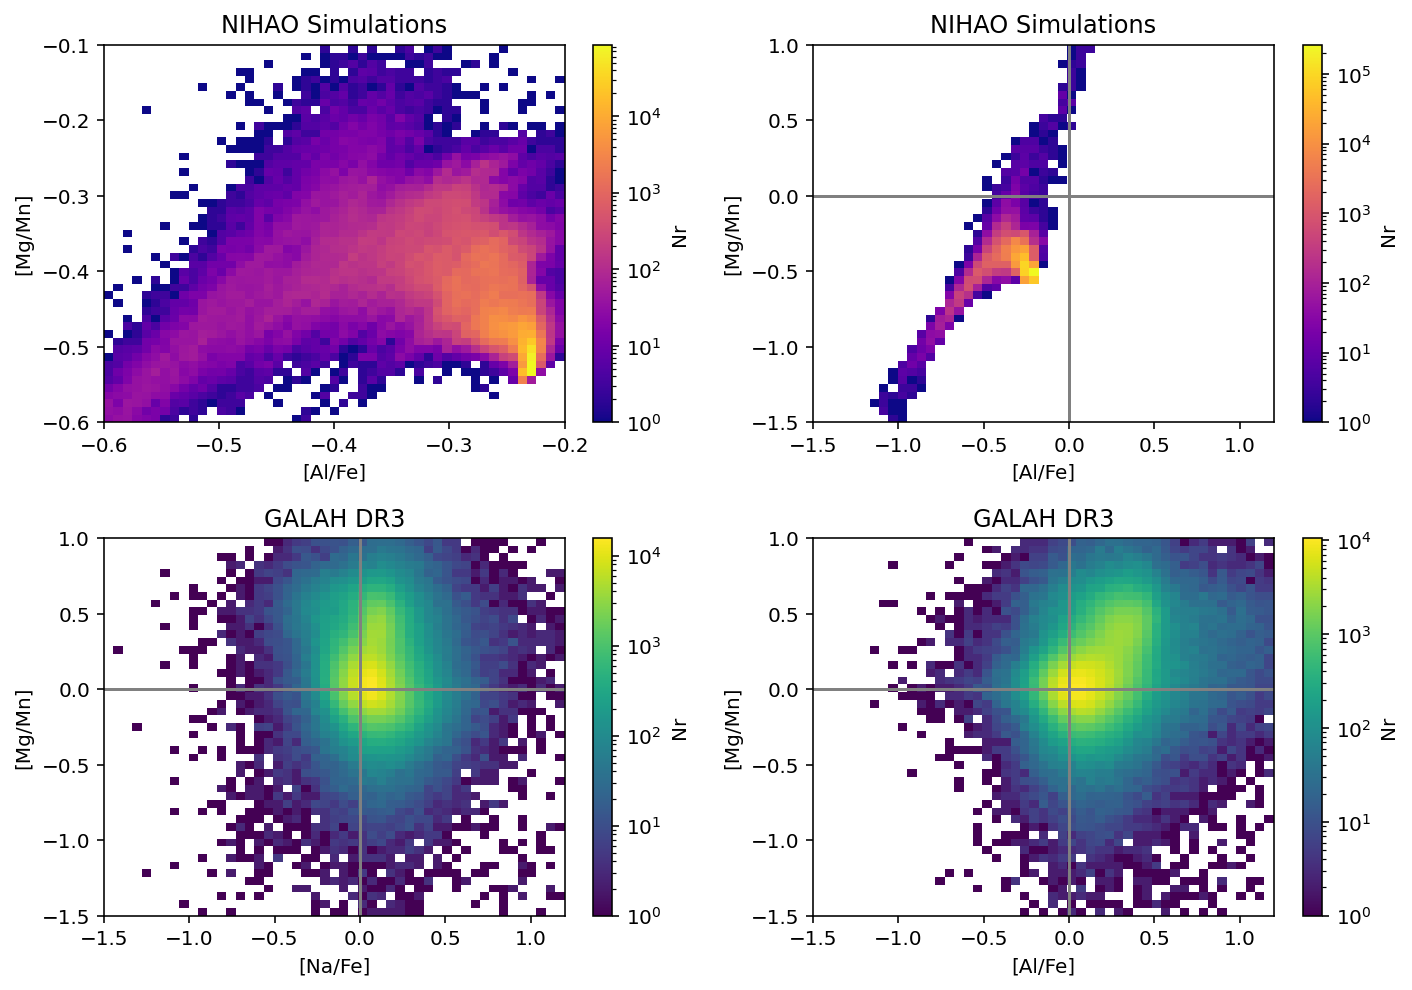

In [11]:
f, gs = plt.subplots(2,2,figsize=(10,7))#,sharex=True,sharey=True)

# Simulation: axes adjusted to show detail of plot
ax = gs[0,0]
p, x, y, s = ax.hist2d(
    sim['Al_H']-sim['Fe_H'],
    sim['Mg_H']-sim['Mn_H'],
    bins = (np.linspace(-0.6, -0.2, 50), np.linspace(-0.6, -0.1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr')
ax.set_xlabel('[Al/Fe]')
ax.set_ylabel('[Mg/Mn]')
s.set_cmap('plasma')
ax.set_title('NIHAO Simulations')
ax.axvline(0, color='grey')
ax.axhline(0, color = 'grey')

# Simulation: axes equal to observation plots for comparison
ax = gs[0,1]
p, x, y, s = ax.hist2d(
    sim['Al_H']-sim['Fe_H'],
    sim['Mg_H']-sim['Mn_H'],
    bins = (np.linspace(-1.5, 1.2, 50), np.linspace(-1.5, 1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr')
ax.set_xlabel('[Al/Fe]')
ax.set_ylabel('[Mg/Mn]')
ax.set_title('NIHAO Simulations')
s.set_cmap('plasma')
ax.axvline(0, color='grey')
ax.axhline(0, color = 'grey')

# Observation: against Na instead of Al, due to better observations 
ax = gs[1,0]
p, x, y, s = ax.hist2d(
    obs['Na_fe'],
    obs['Mg_fe']-obs['Mn_fe'],
    bins = (np.linspace(-1.5, 1.2, 50), np.linspace(-1.5, 1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr')
ax.set_xlabel('[Na/Fe]')
ax.set_ylabel('[Mg/Mn]')
ax.set_title('GALAH DR3')
s.set_cmap('viridis')
ax.axvline(0, color='grey')
ax.axhline(0, color = 'grey')

# Observation: against Al to compare to simulations
ax = gs[1,1]
p, x, y, s = ax.hist2d(
    obs['Al_fe'],
    obs['Mg_fe']-obs['Mn_fe'],
    bins = (np.linspace(-1.5, 1.2, 50), np.linspace(-1.5, 1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s,  ax=ax)
c.set_label('Nr')
ax.set_xlabel('[Al/Fe]')
ax.set_ylabel('[Mg/Mn]')
ax.set_title('GALAH DR3')
ax.axvline(0, color='grey')
ax.axhline(0, color = 'grey')
s.set_cmap('viridis')
plt.tight_layout()

plt.savefig('[Mg_Mn]_[Al_Fe].png', dpi=200,bbox_inches='tight')


# Part 4: Elemental abundance over time

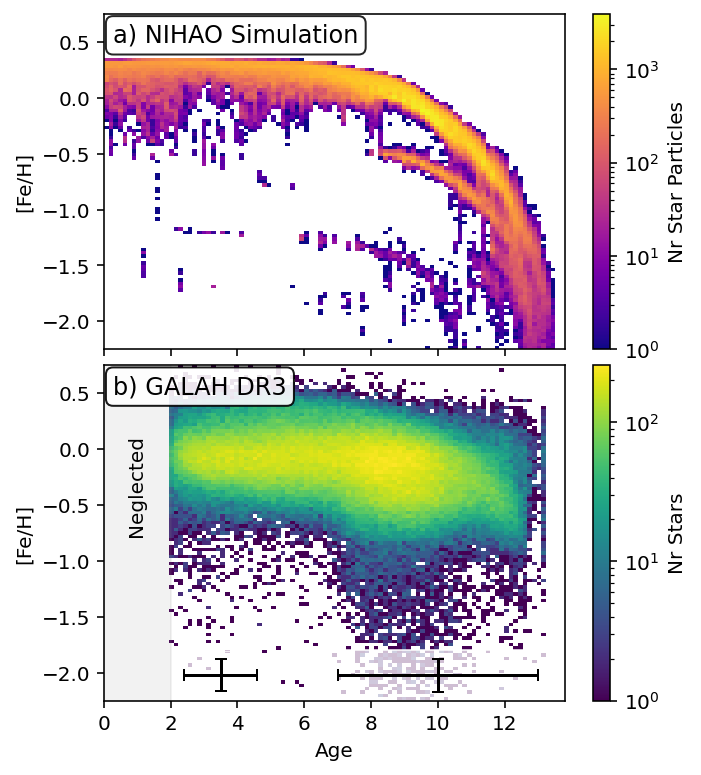

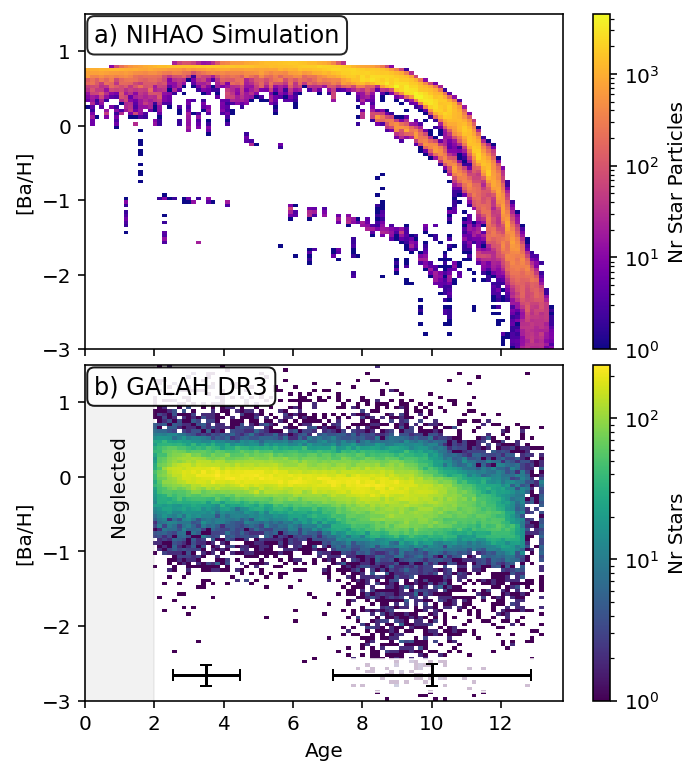

In [12]:
def plot_x_h_over_time(element = 'Fe'):
    
    f, gs = plt.subplots(2,1,figsize=(5,5.5),sharex=True,sharey=True)

    x_bins = np.linspace(0, 13.8, 100)
    if element == 'Fe':
        y_bins = np.linspace(-2.25, 0.75, 100)
    else:
        y_bins = np.linspace(-3, 1.5, 100)

    # Simulation data 
    ax = gs[0]
    ax.text(0.02,0.915,'a) NIHAO Simulation',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        # Ensuring plots are over age, and consistent with b_age_step
        13.8 - sim['tform'],
        sim[element+'_H'],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()

    );
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Star Particles')
    s.set_cmap('plasma')
    ax.set_ylabel('['+element+'/H]')
    plt.tight_layout()

    # Quality cut of GALAH data 
    if element == 'Fe':
        quality_cut = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) & 
            (obs['e_fe_h'] < 0.1) & 
            (obs['age_bstep'] > 2) &
            (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
        )
        ydata = obs['fe_h']
        e_ydata = obs['e_fe_h']
    else:
        quality_cut = (
            (obs['flag_sp'] == 0) &
            (obs['flag_fe_h'] == 0) & 
            (obs['flag_'+element+'_fe'] == 0) & 
            (obs['e_'+element+'_fe'] < 0.1) & 
            (obs['age_bstep'] > 2) &
            (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
        )
        ydata = obs[element+'_fe'] + obs['fe_h']
        e_ydata = obs['e_'+element+'_fe']
        
    ax = gs[1]
    ax.text(0.02,0.915,'b) GALAH DR3',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][quality_cut],
        ydata[quality_cut],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()
    );
    ax.axvspan(0,2,color='grey',alpha=0.1)
    ax.text(0.05,0.5,'Neglected',rotation=90,color='k',transform=ax.transAxes)

    error_position = [
        10,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] > 7) & (obs['fe_h'] < -0.7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    error_position = [
        3.5,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] <7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Stars')
    ax.set_xlabel('Age')
    ax.set_ylabel('['+element+'/H]')
    plt.tight_layout(h_pad=0)

    #plt.savefig('figures/'+element+'_H_time.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()
    
plot_x_h_over_time()
plot_x_h_over_time(element='Ba')

## Ba/Fe over Age 

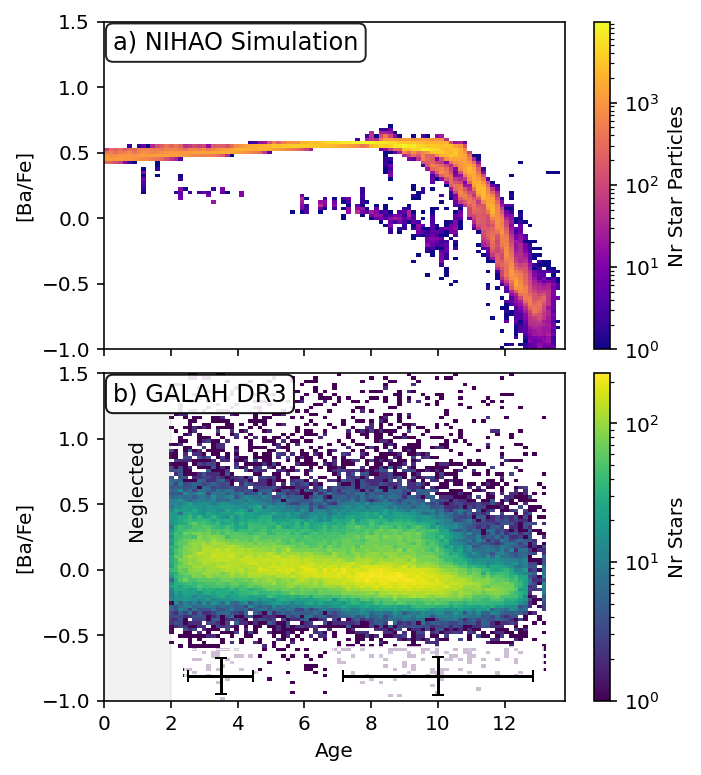

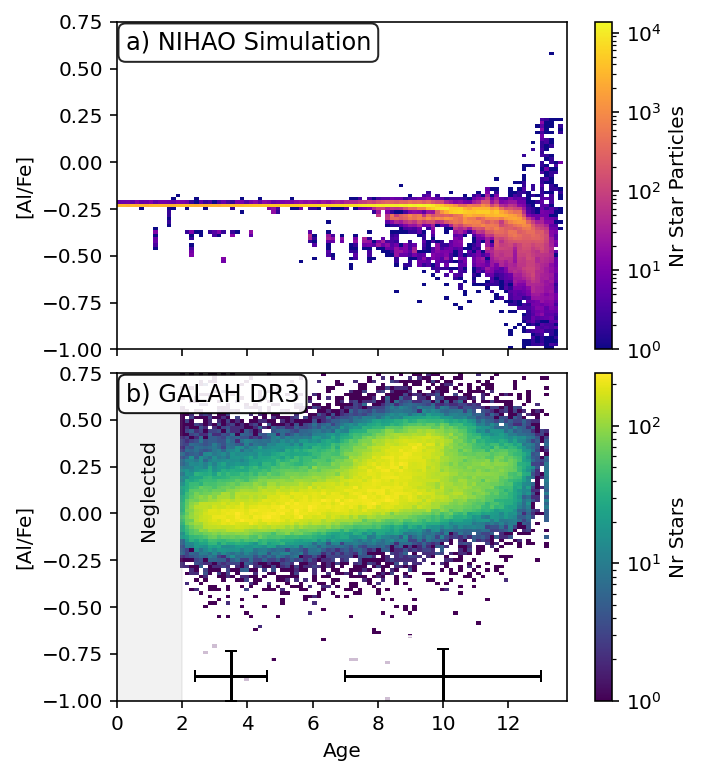

In [13]:
def plot_x_fe_over_time(element = 'Fe'):
    
    f, gs = plt.subplots(2,1,figsize=(5,5.5),sharex=True,sharey=True)

    x_bins = np.linspace(0, 13.8, 100)
    if element == 'Ba':
        y_bins = np.linspace(-1, 1.5, 100)
    elif element == 'Al':
        y_bins = np.linspace(-1, 0.75, 100)
    else:
        y_bins = np.linspace(-1, 1.5, 100)

    # Simulation data 
    ax = gs[0]
    ax.text(0.02,0.915,'a) NIHAO Simulation',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        # Ensuring plots are over age, and consistent with b_age_step
        13.8 - sim['tform'],
        sim[element+'_H']-sim['Fe_H'],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()

    );
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Star Particles')
    s.set_cmap('plasma')
    ax.set_ylabel('['+element+'/Fe]')
    plt.tight_layout()

    # Quality cut of GALAH data 
    quality_cut = (
        (obs['flag_sp'] == 0) &
        (obs['flag_fe_h'] == 0) & 
        (obs['flag_'+element+'_fe'] == 0) & 
        (obs['e_'+element+'_fe'] < 0.1) & 
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5)
    )
    ydata = obs[element+'_fe']
    e_ydata = obs['e_'+element+'_fe']
        
    ax = gs[1]
    ax.text(0.02,0.915,'b) GALAH DR3',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.9))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][quality_cut],
        ydata[quality_cut],
        bins = (x_bins, y_bins),
        cmin = 1,
        norm = colors.LogNorm()
    );
    ax.axvspan(0,2,color='grey',alpha=0.1)
    ax.text(0.05,0.5,'Neglected',rotation=90,color='k',transform=ax.transAxes)

    error_position = [
        10,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] > 7) & (obs['fe_h'] < -0.7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    error_position = [
        3.5,
        0.925*y_bins[0]+0.075*y_bins[-1],
    ]
    quality_cut2 = quality_cut & (obs['age_bstep'] <7)
    xerr = np.median(obs['e_age_bstep'][quality_cut2])
    yerr = 2*np.median(e_ydata[quality_cut2])
    
    polygon = Polygon(
        [
            [error_position[0]-1.1*xerr,error_position[1]-1.5*yerr],
            [error_position[0]-1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]+1.5*yerr],
            [error_position[0]+1.1*xerr,error_position[1]-1.5*yerr],
        ], 
        True,
        fill=True,
        color='w',
        alpha=0.75
    )
    ax.add_patch(polygon)
    
    ax.errorbar(
        error_position[0],error_position[1],xerr=xerr,yerr=yerr,
        capsize=3,color='k',ecolor='k',fillstyle='full'
    )
    
    c = plt.colorbar(s, ax=ax)
    c.set_label('Nr Stars')
    ax.set_xlabel('Age')
    ax.set_ylabel('['+element+'/Fe]')
    plt.tight_layout(h_pad=0)

    #plt.savefig('figures/'+element+'_Fe_time.png',dpi=200,bbox_inches='tight')
    plt.show()
    plt.close()
    
plot_x_fe_over_time(element='Ba')
plot_x_fe_over_time(element='Al')

# Part 5: Data analysis: Separation significance and uncertainties 

## Table 1: Separation Significance for in-situ and accreted sequences

In [14]:
# These are 2 Gaussians combined
def gauss2(x,a,x0,sigma,a1,x01,sigma1):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + a1*np.exp(-(x-x01)**2/(2*sigma1**2))

0.13131313131313127 11318


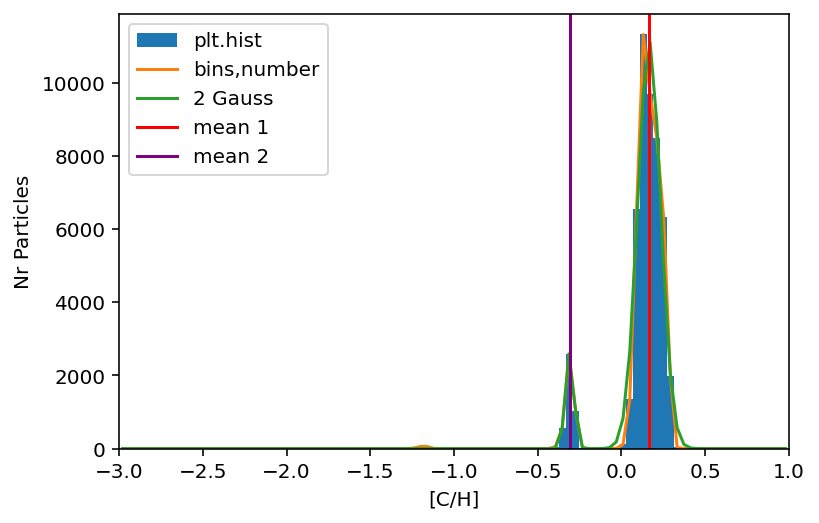

6.482888394008905 0.1662992365817902 0.06851663809414452 -0.3082075008934731 -0.025744735261459473
0.13131313131313127 11790


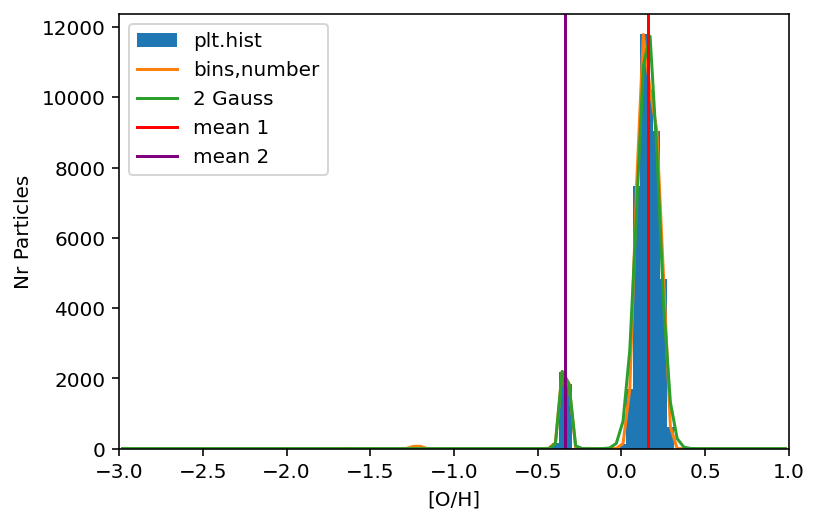

7.28835563138876 0.15903852371943727 0.06374599142574977 -0.3356791508855559 0.023320521172071562
-0.3131313131313129 11333


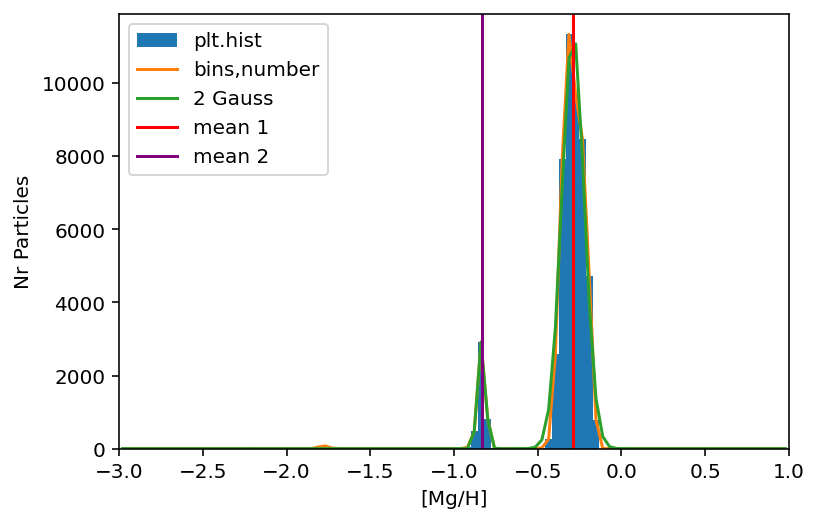

7.732926004847191 -0.2889190288859578 0.06678659462582125 -0.8348870253271825 0.022898437413761134
-0.23232323232323204 10251


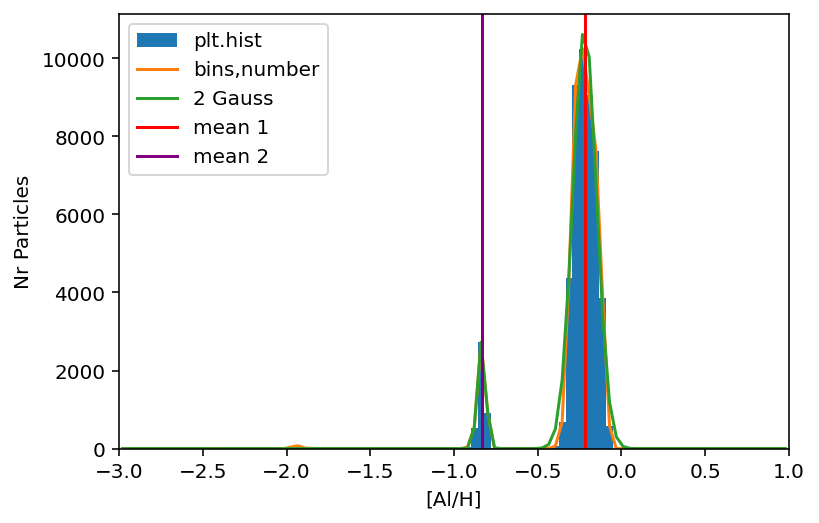

8.226446320115752 -0.21902834410985286 0.07066071896881285 -0.8344272614620052 -0.024560278644381758
0.21212121212121215 10617


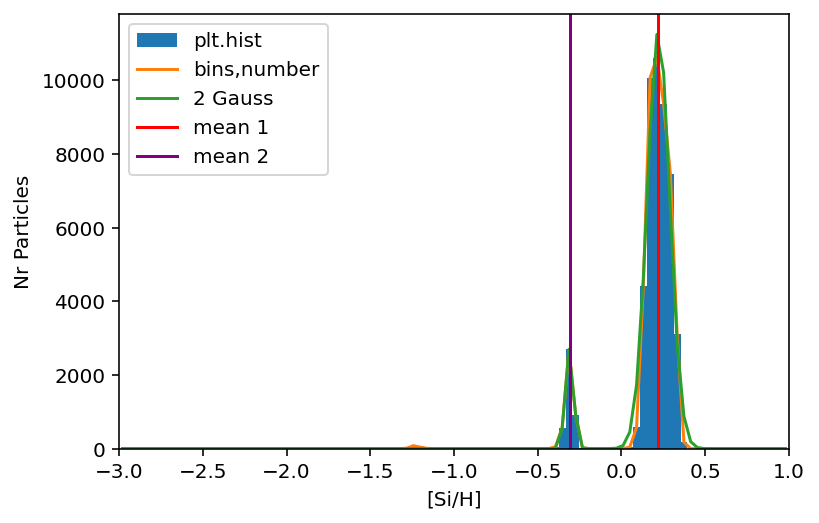

7.400650726039737 0.22149292005027993 0.06731201335188297 -0.3094313808592735 0.024814347142142403
-0.15151515151515116 10415


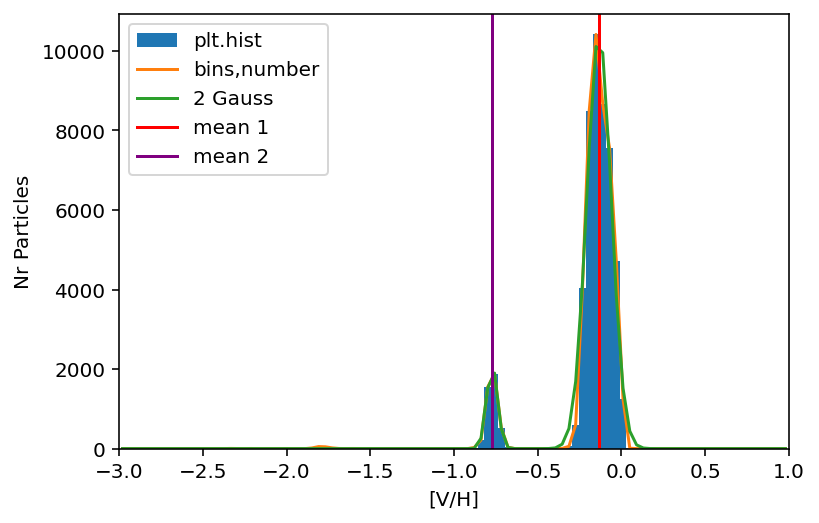

7.991334641849461 -0.133368835723883 0.07305063965381425 -0.7721299428984147 0.0324450857815561
0.010101010101010166 11012


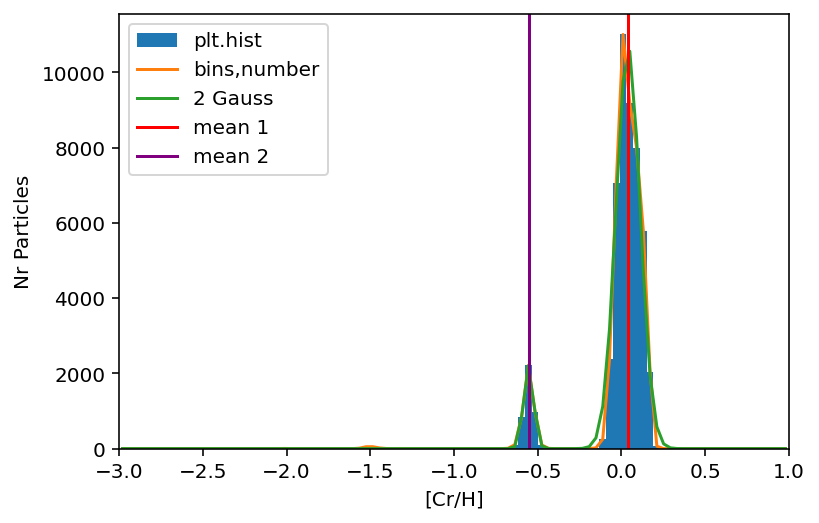

7.6717153519309775 0.04015815227946623 0.07125073769872221 -0.5540113161911391 0.030360109250054394
0.17171717171717193 11047


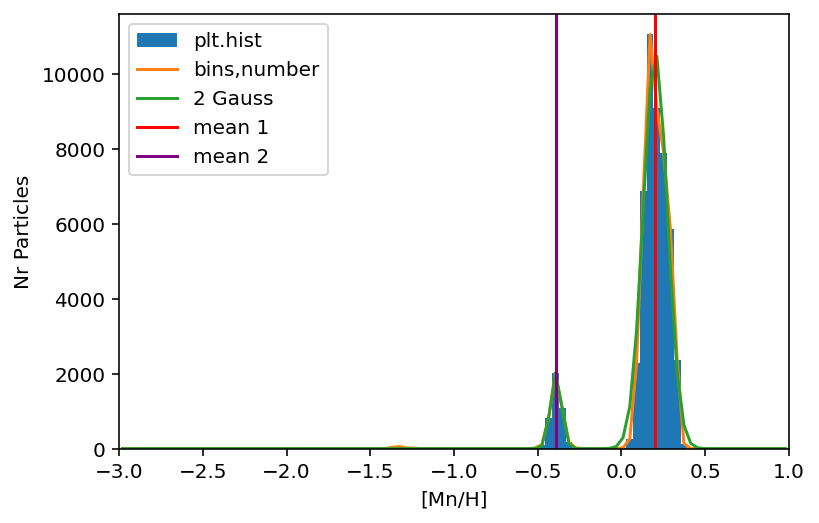

7.489446099004871 0.20288176083224968 0.07199292363173658 -0.3902068570775802 0.032985784269637934
-0.15151515151515116 10579


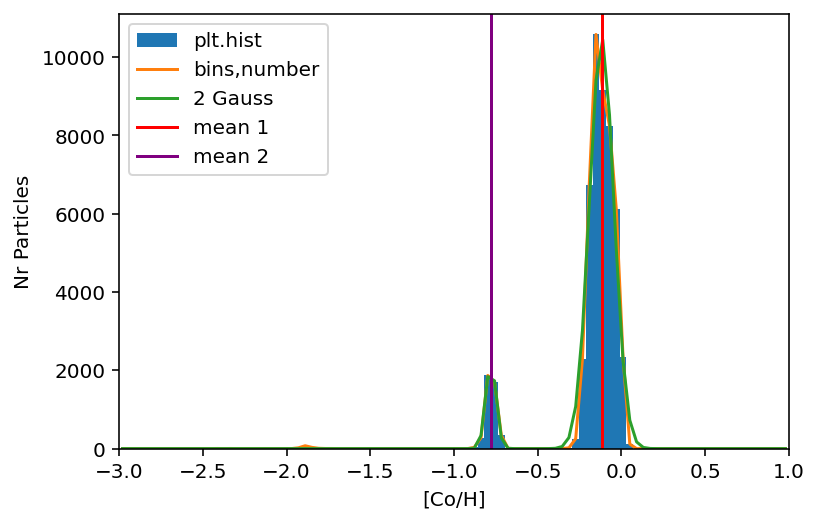

8.394714022598704 -0.11759655523589757 0.07270448129438423 -0.7791567168577542 0.030406625135361468
0.5353535353535357 9929


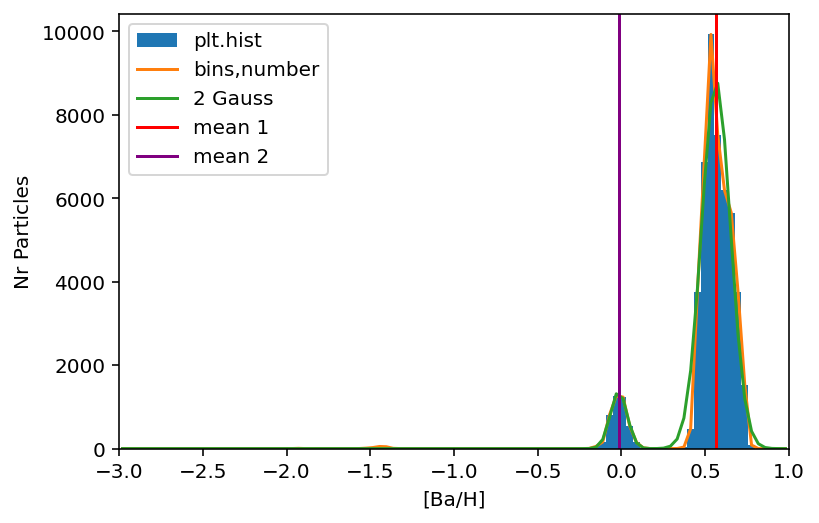

5.85264841749873 0.565458043701972 0.08593493273805682 -0.015868913517186646 0.04981036475426665


In [15]:
# Defining the skeleton of the table 
table_text = [
    [r'\begin{table}'],
    [r'    \centering'],
    [r'    \caption{Separation significance for the simulated data between in-situ and accreted (accr.) sequences for abundances ratios [X/H] of ten elements X.}'],
    [r'    \begin{tabular}{cccccc}'],
    [r'    \hline'],
    [r'    Element & $\mu_\text{in-situ}$ & $\sigma_\text{in-situ}$ & $\mu_\text{accr.}$ & $\sigma_\text{accr.}$ & $r$\\'],
    [r'    \hline \hline']
]

def get_initial_mean_and_sigma(element, debug=True):
    age_limits = (sim['tform'] > 4.5) & (sim['tform'] < 5)
    data = sim[element+'_H'][age_limits]
    p = np.histogram(data,bins=np.linspace(-3,1,100))

    # Numbers and bin middle (from 101 bin beginnings/ends)
    number = p[0]
    bins = p[1][:-1] + 0.5*(p[1][1]-p[1][0])

    peak_bin = bins[np.argmax(number)]
    peak_number = number[np.argmax(number)]
    print(peak_bin,peak_number)
    
    # This is simply "fitting" the 2 Gaussians to our data
    popt,pcov = curve_fit(
        gauss2,
        xdata = bins,
        ydata = number,
        p0=[peak_number,peak_bin,0.25,0.25*peak_number,peak_bin-0.5,0.1]
    )

    mean1 = popt[1]
    sigma1 = popt[2]
    mean2 = popt[4]
    sigma2 = popt[5]
    
    r = abs(mean1 - mean2) / np.sqrt(sigma1**2 + sigma2**2) 
    
    if debug:
        plt.hist(
            data,bins=np.linspace(-3,1,100),
            label='plt.hist'
        )
        plt.plot(
            bins,
            number,
            label='bins,number'
        )
        
        plt.plot(
            bins,
            gauss2(bins,*popt),
            label='2 Gauss'
        )
        
        plt.xlim(-3,1)
        
        plt.axvline(mean1,c='r',label='mean 1')
        plt.axvline(mean2,c='purple',label='mean 2')
        plt.legend()
        
        plt.xlabel('['+element+'/H]')
        plt.ylabel('Nr Particles')
        
        plt.show()
        plt.close()
        
        print(r,mean1,sigma1,mean2,sigma2)

#     # Code that computes mu, sigma, r
#     p16, p50, p84 = np.percentile(sim[''+element+'_H'][low], q=[16,50,84])
#     mu_1 = p50
#     sigma_1 = (p84-p16)/2
    
#     p16, p50, p84 = np.percentile(sim[''+element+'_H'][high], q=[16,50,84])
#     mu_2 = p50
#     sigma_2 = (p84-p16)/2
    
#    r = abs(mu_1 - mu_2) / np.sqrt(sigma_1**2 + sigma_2**2) 
    
    return(r'    {['+element+'/H]}  & '+str(round(mean1,2))+' & '+str(round(sigma1, 2))+' & '+str(round(mean2, 2))+' & '+str(round(sigma2, 2))+' & '+str(round(r, 2))+r' \\')

# Creating a loop for the table to run through each element 
for element in ['C', 'O', 'Mg', 'Al', 'Si',  'V', 'Cr', 'Mn','Co', 'Ba']:
    table_text.append([get_initial_mean_and_sigma(element)])

table_text.append([r'    \hline'])
table_text.append([r'    \end{tabular}'])
table_text.append([r'    \label{tab:r_values_simulation}'])
table_text.append([r'\end{table}'])

np.savetxt('tables/separation_significance_two_sequences.tex',table_text,fmt='%s')


[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
[1.1817148925687102, 1.186476254402387, 1.2773280705371821, 1.4514960156716088, 1.1058961465268777, 1.0945930675855424, 3.405039378480058, 5.104990387035202, 6.482871320045948]
[1.1534956112409014, 1.1598233823995978, 1.232802348239505, 1.245653949689008, 1.0164617969889649, 2.844731859759689, 3.8002872176718214, 5.795817243321805, 7.288355282247264]
[1.1609336442139708, 1.1669104252107907, 1.2356199135042476, 1.2533627656206368, 1.053266162573987, 2.8460798971624564, 3.8154539361379243, 5.9598754132735365, 7.732926013450769]
[1.1705480019477368, 1.175173092346287, 1.238590139103047, 1.2591586170361253, 1.0796470576268358, 2.8956142851033384, 3.8777215386553907, 6.118117253037442, 8.226449006383953]
[1.1776755054252162, 1.1860815400105813, 1.2792301398958386, 1.3328298003130656, 1.0294475309579267, 2.805055856360083, 3.758255273327966, 5.729731718558563, 7.400635369162318]
[1.182662595858292, 1.1936834852464815, 1.285542915488357, 1.353391367013746

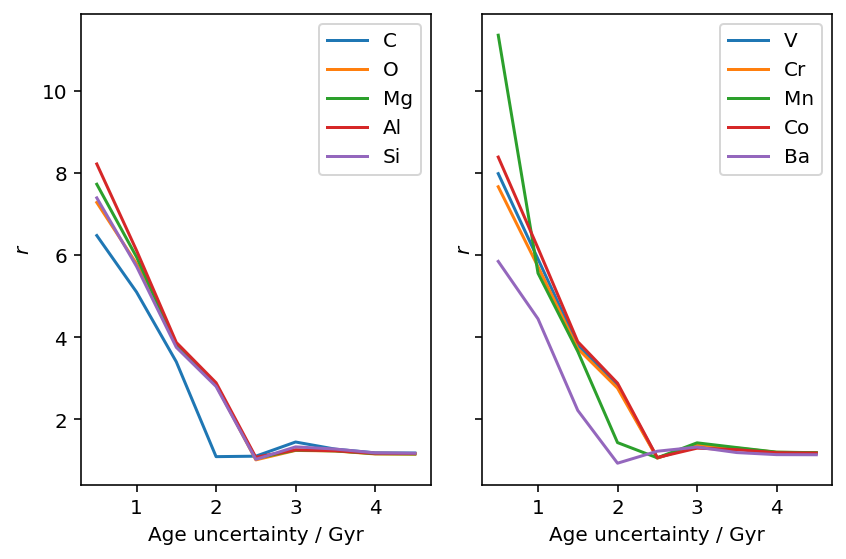

In [75]:
def get_initial_mean_and_sigma(element, age_limits = np.linspace(0.5,4.5,9), debug=True):

    sep_r_array = []
    
    for lower_age in age_limits:
        
        within_age_limits_array = (sim['tform'] > lower_age) & (sim['tform'] < 5)
        data = sim[element+'_H'][within_age_limits_array]

        if debug:
            
            plt.figure()
            
            plt.hist2d(
                sim['tform'],
                sim[element+'_H'],
                cmap='Greys',cmin=1,
                bins = (np.linspace(0,15,100),np.linspace(-2,1,100))
            )
            
            plt.hist2d(
                sim['tform'][within_age_limits_array],
                sim[element+'_H'][within_age_limits_array],
                cmap='Blues',cmin=1,
                bins = (np.linspace(0,15,100),np.linspace(-2,1,100))
            )            
            
            plt.show()
            plt.close()
        
        p = np.histogram(data,bins=np.linspace(-3,1,100))

        # Numbers and bin middle (from 101 bin beginnings/ends)
        number = p[0]
        bins = p[1][:-1] + 0.5*(p[1][1]-p[1][0])

        peak_bin = bins[np.argmax(number)]
        peak_number = number[np.argmax(number)]

        # This is simply "fitting" the 2 Gaussians to our data
        popt,pcov = curve_fit(
            gauss2,
            xdata = bins,
            ydata = number,
            p0=[peak_number,peak_bin,0.25,0.5*peak_number,peak_bin-0.7,0.1]
        )

        mean1 = popt[1]
        sigma1 = popt[2]
        mean2 = popt[4]
        sigma2 = popt[5]

        r = abs(mean1 - mean2) / np.sqrt(sigma1**2 + sigma2**2) 

        if debug:
            plt.hist(
                data,bins=np.linspace(-3,1,100),
                label='plt.hist'
            )
            plt.plot(
                bins,
                number,
                label='bins,number'
            )

            plt.plot(
                bins,
                gauss2(bins,*popt),
                label='2 Gauss'
            )

            plt.xlim(-3,1)

            plt.axvline(mean1,c='r',label='mean 1')
            plt.axvline(mean2,c='purple',label='mean 2')
            plt.legend()

            plt.xlabel('['+element+'/H]')
            plt.ylabel('Nr Particles')

            plt.show()
            plt.close()

        sep_r = abs(mean1 - mean2) / np.sqrt(sigma1**2 + sigma2**2)
        sep_r_array.append(sep_r)
        
    print(sep_r_array)

    return sep_r_array

age_limits = np.linspace(0.5,4.5,9)
print(age_limits)

sep_r_values = dict()

f, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True)

for element in ['C', 'O', 'Mg', 'Al', 'Si']:

    sep_r_values[element] = get_initial_mean_and_sigma(element,age_limits,debug=False)

    ax1.plot(
        5 - age_limits,
        sep_r_values[element],
        label=element
    )
ax1.legend()

for element in ['V', 'Cr', 'Mn','Co', 'Ba']:
    sep_r_values[element] = get_initial_mean_and_sigma(element,age_limits,debug=False)

    ax2.plot(
        5 - age_limits,
        sep_r_values[element],
        label=element
    )
ax2.legend()

ax1.set_xlabel('Age uncertainty / Gyr')
ax2.set_xlabel('Age uncertainty / Gyr')
ax1.set_ylabel('$r$')
ax2.set_ylabel('$r$')
plt.tight_layout()

plt.savefig('figures\Age_vs_r.png')

# Table 2
## Measurement uncertainties required for significance

In [78]:
# First, defining the function that will calculate the mean and sigma values for each Gaussianyes 

def get_initial_mean_and_sigma(element, debug=False):
    age_limits = (sim['tform'] > 4) & (sim['tform'] < 5)
    data = sim[element+'_H'][age_limits]
    p = np.histogram(data,bins=100)

    # Numbers and bin middle (from 101 bin beginnings/ends)
    number = p[0]
    bins = p[1][:-1] + 0.5*(p[1][1]-p[1][0])

    peak_bin = bins[np.argmax(number)]
    peak_number = number[np.argmax(number)]

    # This is simply "fitting" the 2 Gaussians to our data
    popt,pcov = curve_fit(
        gauss2,
        xdata = bins,
        ydata = number,
        p0=[peak_number,peak_bin,0.25,0.5*peak_number,peak_bin-0.7,0.1]
    )

    mean1 = popt[1]
    sigma1 = popt[2]
    mean2 = popt[4]
    sigma2 = popt[5]

    if debug:
        plt.hist(
            data,bins=np.linspace(-3,1,100),
            label='plt.hist'
        )
        plt.plot(
            bins,
            number,
            label='bins,number'
        )

        plt.plot(
            bins,
            gauss2(bins,*popt),
            label='2 Gauss'
        )

        plt.xlim(-3,1)

        plt.axvline(mean1,c='r',label='mean 1')
        plt.axvline(mean2,c='purple',label='mean 2')
        plt.legend()

        plt.xlabel('['+element+'/H]')
        plt.ylabel('Nr Particles')

        plt.show()
        plt.close()
    

    
    # Obtaining the mean error of the measurements taken by GALAH 
    mean_error = np.mean((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])])

    # Calculating what percentage of the stars observed had measurements available for each element 
    number_observations= (len((obs['e_'+element+'_fe'])))
    non_zero_number = (len((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])]))
    fraction_available = non_zero_number/number_observations
    percent_available = fraction_available*100

    return(mean1, sigma1, mean2, sigma2, mean_error)
#     # Defining the columns of Table 2, found in the paper
#     return(mean1, sigma1, mean2, sigma2, mean_error)

 


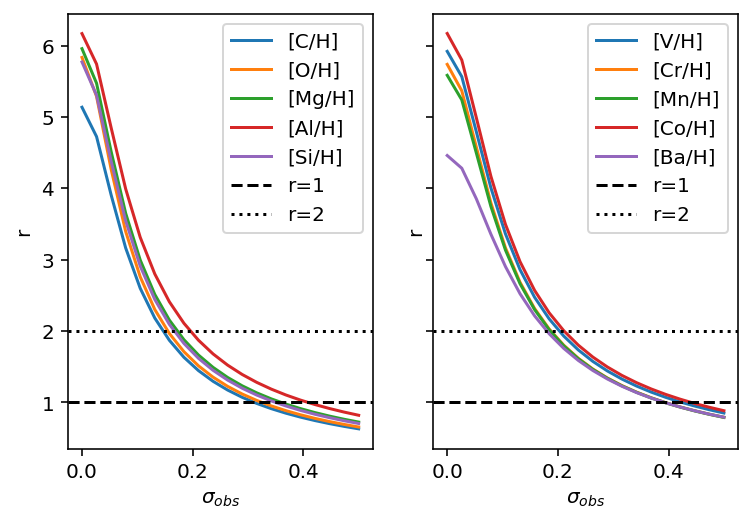

In [99]:
f, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True)

for element in ['C', 'O', 'Mg', 'Al', 'Si']:
    
    peaks = get_initial_mean_and_sigma(element)
    
    sigma_obs = np.linspace(0,0.5,20)
    sigma_1obs = np.sqrt(peaks[1]**2 + sigma_obs**2)
    sigma_2obs = np.sqrt(peaks[3]**2 + sigma_obs**2)
    r_obs = abs(peaks[0] - peaks[2]) / np.sqrt(sigma_1obs**2 + sigma_2obs**2) 
    r_sim = abs(peaks[0] - peaks[2]) / np.sqrt(peaks[1]**2 + peaks[3]**2) 

    # Interpolate and find sigma_obs values that match r=1, 2
    r_1_68 = sigma_obs[np.argmin(np.abs(r_obs - 1))]
    r_1_95 = sigma_obs[np.argmin(np.abs(r_obs - 2))]

    ax1.plot(
        sigma_obs,
        r_obs,
        label='['+element+'/H]'
    )
ax1.set_xlabel('$\sigma_{obs}$')
ax1.set_ylabel('r')
ax1.axhline(1,c='k',ls='dashed',label='r=1')
ax1.axhline(2, c='k',ls='dotted',label='r=2')
ax1.legend()

for element in ['V', 'Cr', 'Mn','Co', 'Ba']:
    
    peaks = get_initial_mean_and_sigma(element)
    
    #sep_r_values[element] = get_initial_mean_and_sigma(element,age_limits,debug=False)
    sigma_obs = np.linspace(0,0.5,20)
    sigma_1obs = np.sqrt(peaks[1]**2 + sigma_obs**2)
    sigma_2obs = np.sqrt(peaks[3]**2 + sigma_obs**2)
    r_obs = abs(peaks[0] - peaks[2]) / np.sqrt(sigma_1obs**2 + sigma_2obs**2) 
    r_sim = abs(peaks[0] - peaks[2]) / np.sqrt(peaks[1]**2 + peaks[3]**2) 

    # Interpolate and find sigma_obs values that match r=1, 2
    r_1_68 = sigma_obs[np.argmin(np.abs(r_obs - 1))]
    r_1_95 = sigma_obs[np.argmin(np.abs(r_obs - 2))]

    ax2.plot(
        sigma_obs,
        r_obs,
        label='['+element+'/H]'
    )
ax2.set_xlabel('$\sigma_{obs}$')
ax2.set_ylabel('r')
ax2.axhline(1,c='k',ls='dashed',label='r=1')
ax2.axhline(2, c='k',ls='dotted',label='r=2')
ax2.legend()



plt.savefig('Element_vs_r')

#np.savefig('figures/sigma_obs_vs_r.tex',table_text_2,fmt='%s')

In [67]:
table_text_2 = [
    [r'\begin{table}'],
    [r'    \centering'],
    [r'    \caption{Observational uncertainties for each element that allow to separate the in-situ and accreted sequences at $8-9\,\mathrm{Gyr}$ with 95\% ($r>2$) and 68\% ($r>1$) certainty. The last rows report the percentage of measurements and their the median uncertainties for the element reported by GALAH DR3 (as indicators of how often and how well the element can be measured.}'],
    [r'    \begin{tabular}{ccccc}'],
    [r'    \hline'],
    [r'    Element & $\sigma_\text{obs}$ 95\% & $\sigma_\text{obs}$ 68\% & Det. Rate & $\sigma_\text{GALAH}$ \\'],
    [r'    \hline \hline']
]



def get_initial_mean_and_sigma(element, debug=False):
    age_limits = (sim['tform'] > 4) & (sim['tform'] < 5)
    data = sim[element+'_H'][age_limits]
    p = np.histogram(data,bins=100)

    # Numbers and bin middle (from 101 bin beginnings/ends)
    number = p[0]
    bins = p[1][:-1] + 0.5*(p[1][1]-p[1][0])

    peak_bin = bins[np.argmax(number)]
    peak_number = number[np.argmax(number)]

    # This is simply "fitting" the 2 Gaussians to our data
    popt,pcov = curve_fit(
        gauss2,
        xdata = bins,
        ydata = number,
        p0=[peak_number,peak_bin,0.25,0.5*peak_number,peak_bin-0.7,0.1]
    )

    mean1 = popt[1]
    sigma1 = popt[2]
    mean2 = popt[4]
    sigma2 = popt[5]

    if debug:
        plt.hist(
            data,bins=np.linspace(-3,1,100),
            label='plt.hist'
        )
        plt.plot(
            bins,
            number,
            label='bins,number'
        )

        plt.plot(
            bins,
            gauss2(bins,*popt),
            label='2 Gauss'
        )

        plt.xlim(-3,1)

        plt.axvline(mean1,c='r',label='mean 1')
        plt.axvline(mean2,c='purple',label='mean 2')
        plt.legend()

        plt.xlabel('['+element+'/H]')
        plt.ylabel('Nr Particles')

        plt.show()
        plt.close()
    

### NEED TO RENAME VARIABLES TO BE CLEARER
### HOW WAS SIGMA_OBS DEFINED?
    sigma_obs = np.linspace(0,0.5,20)
    sigma_1obs = np.sqrt(sigma1**2 + sigma_obs**2)
    sigma_2obs = np.sqrt(sigma2**2 + sigma_obs**2)
    r_obs = abs(mean1 - mean2) / np.sqrt(sigma_1obs**2 + sigma_2obs**2) 
    r_sim = abs(mean1 - mean2) / np.sqrt(sigma1**2 + sigma2**2) 
    
    # Interpolate and find sigma_obs values that match r=1, 2
    r_1_68 = sigma_obs[np.argmin(np.abs(r_obs - 1))]
    r_1_95 = sigma_obs[np.argmin(np.abs(r_obs - 2))]
    
#     plt.axhline(1)
#     plt.axhline(2)
    
    # Obtaining the mean error of the measurements taken by GALAH 
    mean_error = np.mean((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])])

    # Calculating what percentage of the stars observed had measurements available for each element 
    number_observations= (len((obs['e_'+element+'_fe'])))
    non_zero_number = (len((obs['e_'+element+'_fe'])[~np.isnan(obs['e_'+element+'_fe'])]))
    fraction_available = non_zero_number/number_observations
    percent_available = fraction_available*100
        
#     plt.plot(sigma_obs, r_obs, label = '['+element+'/H]')
#     plt.legend()
#     plt.xlabel('$\sigma_{obs}$')
#     plt.ylabel('Separation significance $r$')

    
    #return(mean1, sigma1, mean2, sigma2, mean_error)
    # Defining the columns of Table 2, found in the paper
    return(r'    {['+element+'/H]}  & '+str(round(r_1_95,3))+' & '+str(round(r_1_68, 3))+' & '+str(round(percent_available, 2))+' & '+str(round(mean_error, 3))+r' \\')


 

for element in ['C', 'O', 'Mg', 'Al', 'Si',  'V', 'Cr', 'Mn','Co', 'Ba']:
    table_text_2.append([get_initial_mean_and_sigma(element,debug=False)])

table_text_2.append([r'    \hline'])
table_text_2.append([r'    \end{tabular}'])
table_text_2.append([r'    \label{tab:r_values_simulation}'])
table_text_2.append([r'\end{table}'])

np.savetxt('tables/table_2_test.tex',table_text_2,fmt='%s')

# The potential of Ages: Cleaning chemical selections

It has been shown that ages are extremely helpful in the stellar disk, to separate (typically young) low- from (typically old) high-alpha disk stars (Buder et al. 2019). Both when chemically separating the two disk populations (Buder et al. 2019) as well as accreted stars from in-situ (Buder et al. 2022), significant contamination or overlaps were discovered.

Here, we are now testing the potential of ages as another conserved stellar property to clean the contamination of chemical selections.

We start by selecting accreted stars chemically in the [Na/Fe] vs. [Mg/Fe] plane as done by Buder et al. (2022).

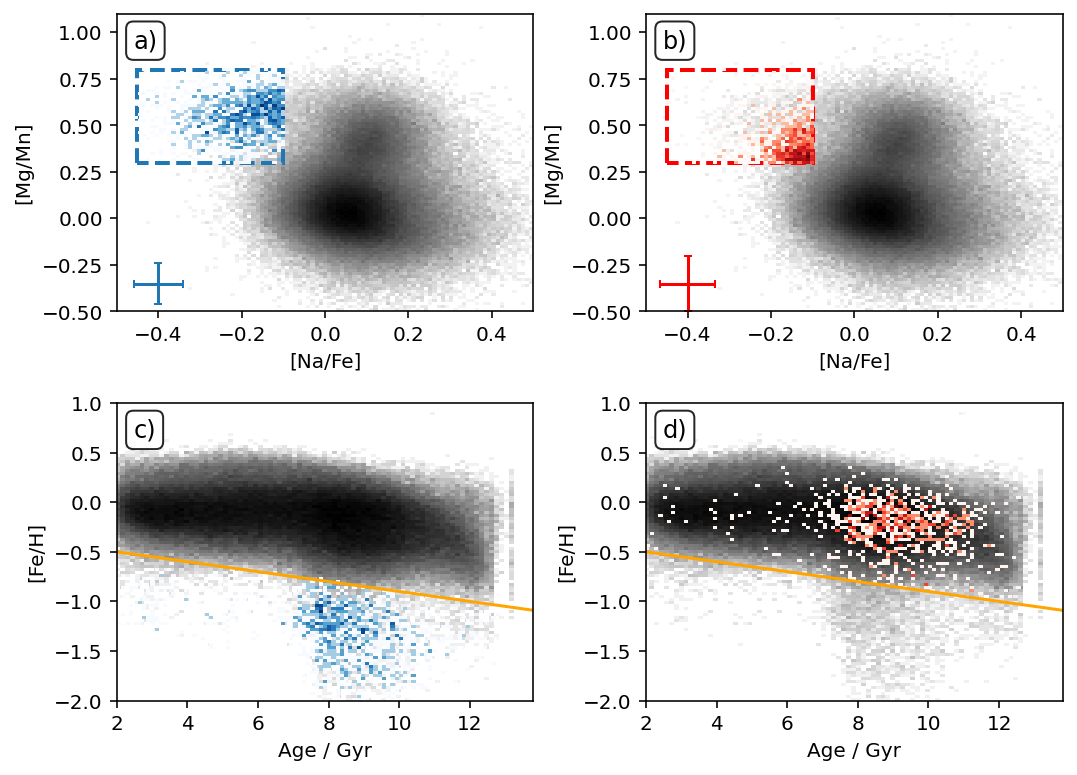

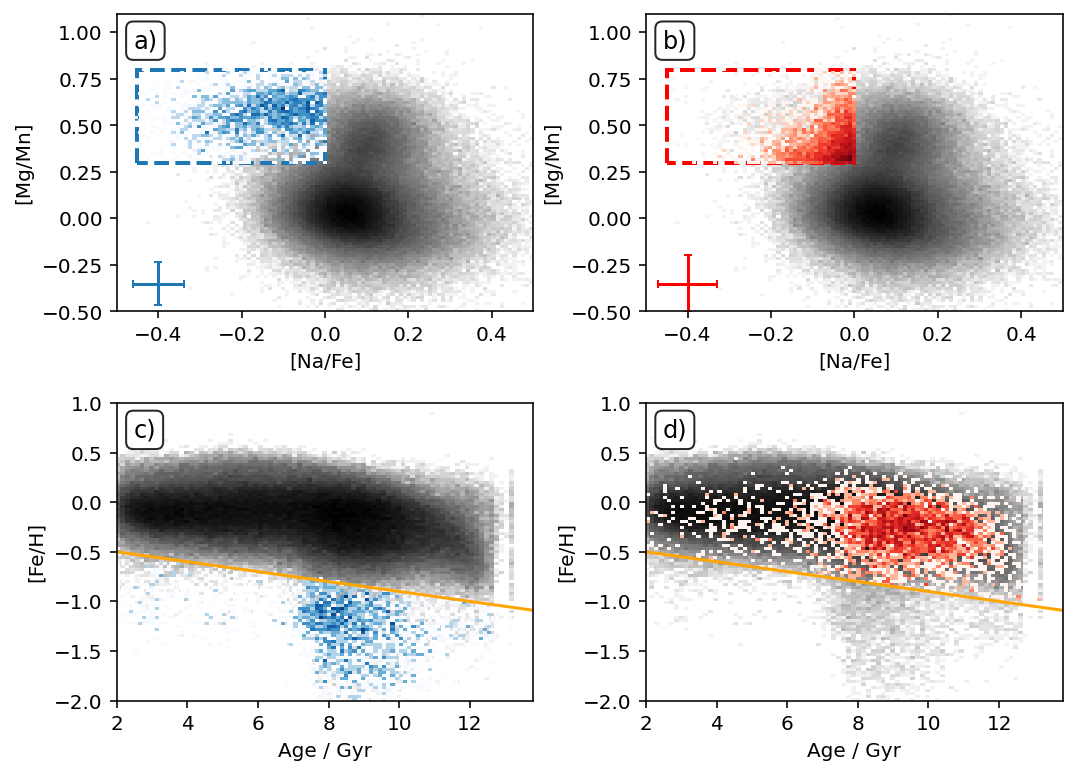

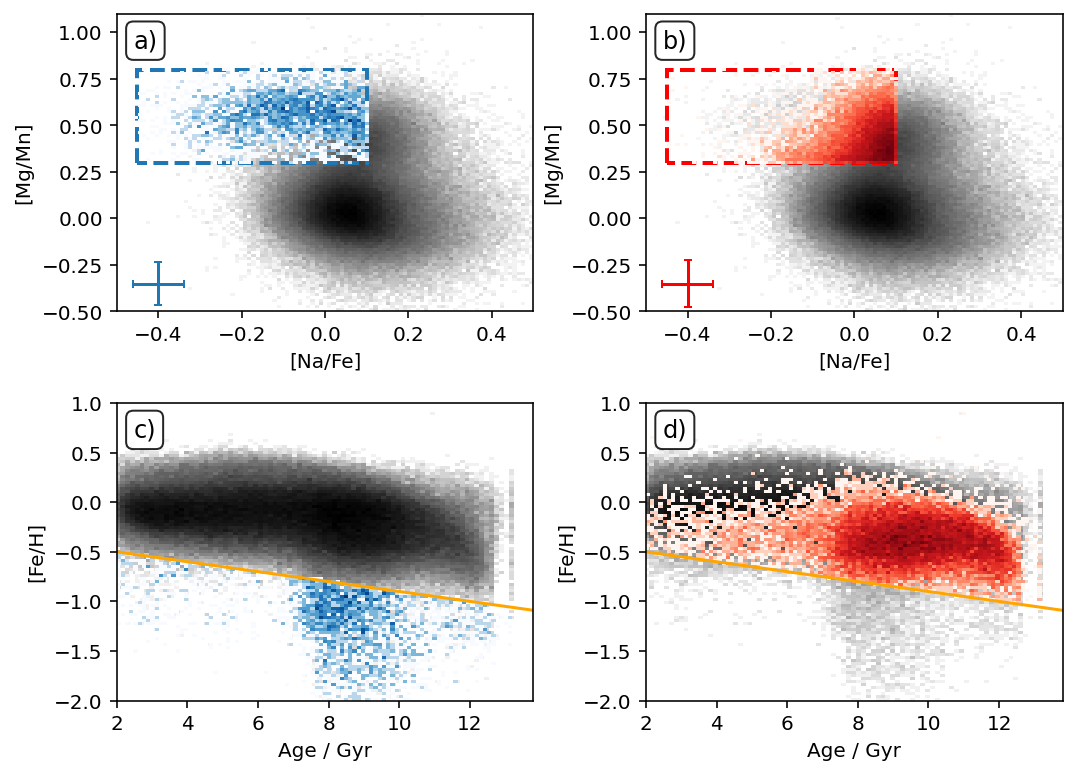

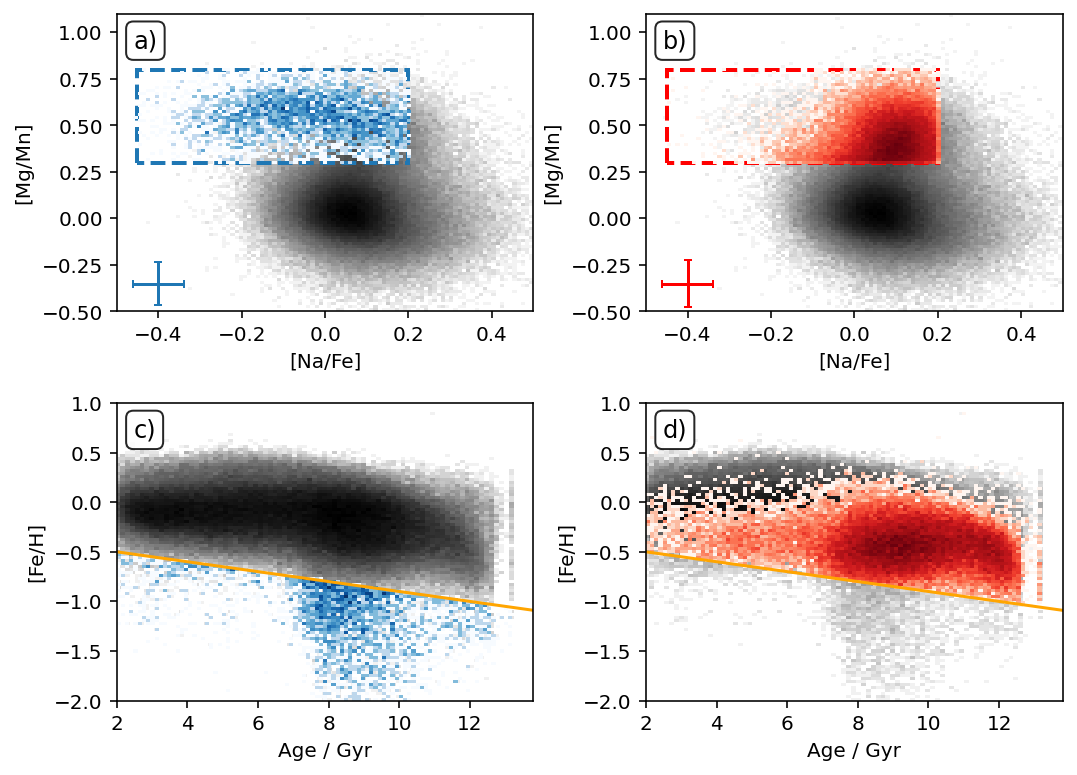

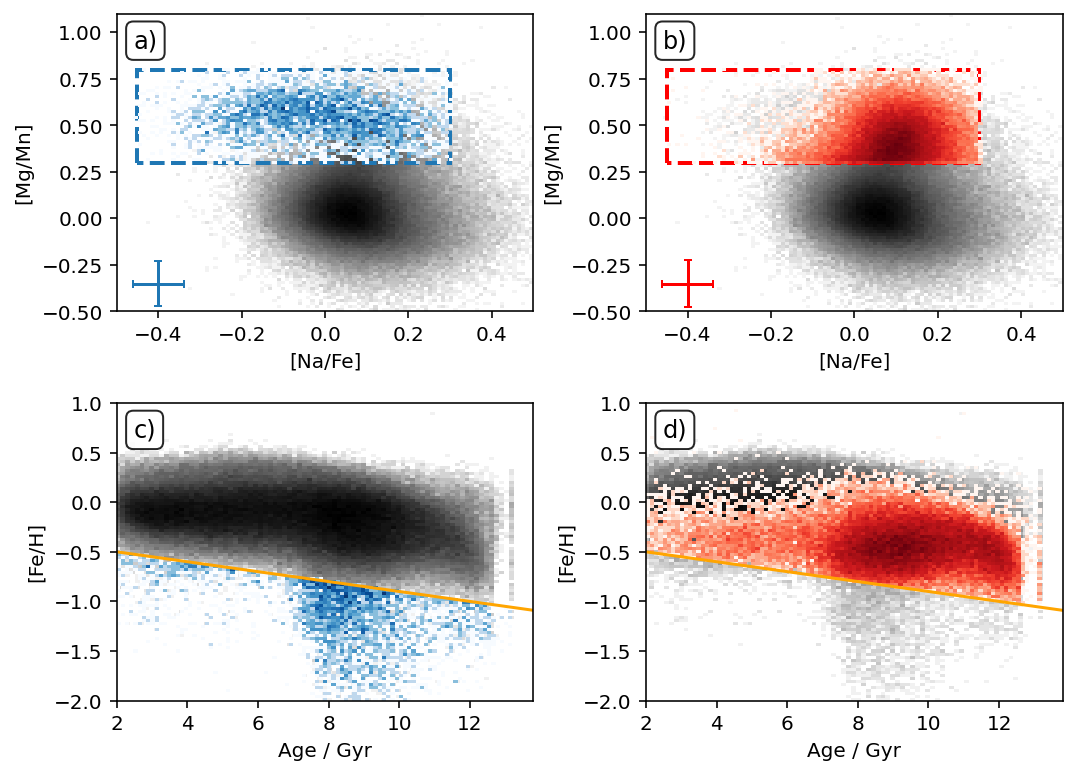

In [21]:
def plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.3], selection_mg_mn = [0.3,0.8], save=False):

    f, gs = plt.subplots(2,2,figsize=(7.5,5.5))

    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,0]
    ax.text(0.04,0.95,'a)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')
    
    selection_accreted = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe[0]) & 
        (obs['Na_fe'] < selection_na_fe[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] < -0.4-0.05*obs['age_bstep'])
    )

    polygon = Polygon(
        [
            [selection_na_fe[0],selection_mg_mn[0]],
            [selection_na_fe[0],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'C0',
        ls = 'dashed',
        lw = 2
    )
    ax.add_patch(polygon)
    ax.set_xlabel('[Na/Fe]')
    ax.set_ylabel('[Mg/Mn]')

    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Blues',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')


    ax.errorbar(
        [-0.4],[-0.35],
        xerr = np.median(obs['e_Na_fe'][selection_accreted]),
        yerr = np.median(np.sqrt(obs['e_Mg_fe'][selection_accreted]**2+obs['e_Mn_fe'][selection_accreted]**2)),
        c = 'C0', capsize=2
    )
    
    ax = gs[1,0]
    ax.text(0.04,0.95,'c)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Blues',
        norm = colors.LogNorm()
    );
#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')
    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )


    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,1]
    ax.text(0.04,0.95,'b)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    ax.set_xlabel('[Na/Fe]')
    ax.set_ylabel('[Mg/Mn]')
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')
        
    selection_accreted = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe[0]) & 
        (obs['Na_fe'] < selection_na_fe[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )

    polygon = Polygon(
        [
            [selection_na_fe[0],selection_mg_mn[0]],
            [selection_na_fe[0],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'r',
        ls = 'dashed',
        lw = 2
    )
    ax.add_patch(polygon)
    
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Reds',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')

    ax.errorbar(
        [-0.4],[-0.35],
        xerr = np.median(obs['e_Na_fe'][selection_accreted]),
        yerr = np.median(np.sqrt(obs['e_Mg_fe'][selection_accreted]**2+obs['e_Mn_fe'][selection_accreted]**2)),
        c = 'red', capsize=2
    )

    ax = gs[1,1]
    ax.text(0.04,0.95,'d)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Reds',
        norm = colors.LogNorm()
    );
#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )
    
    plt.tight_layout()

    if save:
        plt.savefig('figures/NaFe_MgMn_selection_Age_FeH_dissection.png',bbox_inches='tight',dpi=200)
    
    plt.show()
    plt.close()
    
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,-0.1], selection_mg_mn = [0.3,0.8])
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.0], selection_mg_mn = [0.3,0.8])
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.1], selection_mg_mn = [0.3,0.8])
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.2], selection_mg_mn = [0.3,0.8])
plot_nafe_mgmn_dissection(selection_na_fe = [-0.45,0.3], selection_mg_mn = [0.3,0.8], save=True)

In [22]:
for index, nafe_upper_limit in enumerate([0.2,0.1,0.0,-0.1]):
    if index != 1:
        print(index, nafe_upper_limit)

0 0.2
2 0.0
3 -0.1


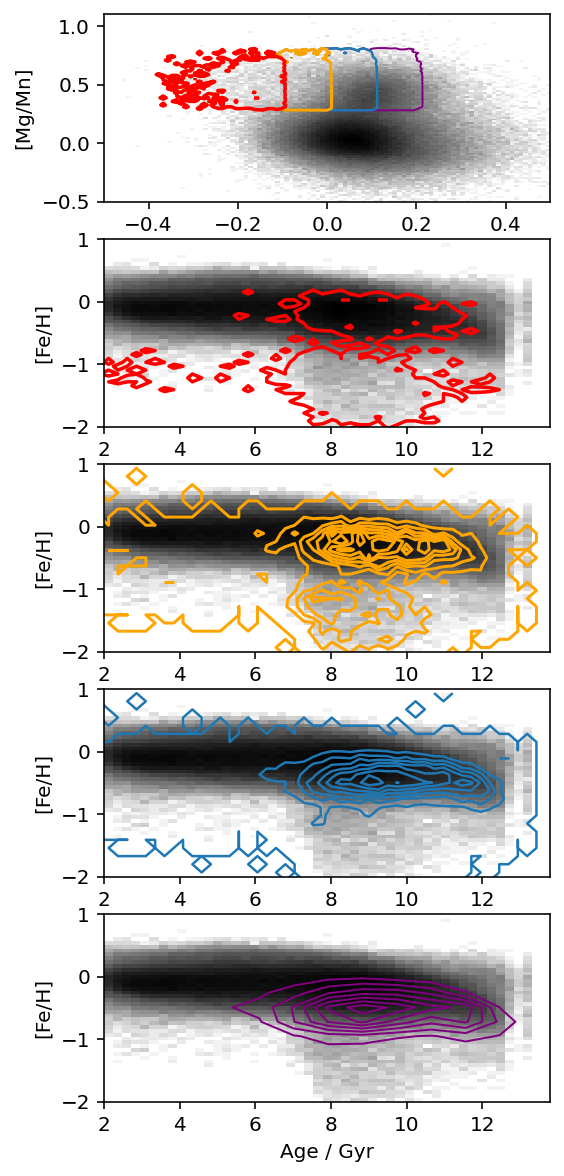

In [23]:
def plot_nafe_selections():
    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )

    f, gs = plt.subplots(5,1,figsize=(4,10))

    colors = ['purple','C0','orange','red']

    for index, nafe_upper_limit in enumerate([0.2,0.1,0.0,-0.1]):

    #     f, gs = plt.subplots(1,2)

        selection_na_fe = [-0.4,nafe_upper_limit]
        selection_mg_mn = [0.3,0.8]

        selection_accreted = (
            observation_quality_check & 
            (obs['Na_fe'] > selection_na_fe[0]) & 
            (obs['Na_fe'] < selection_na_fe[1]) &
            (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
            (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) #& 
            #(obs['fe_h'] < -0.4-0.05*obs['age_bstep'])
        )

        ax = gs[0]

        if index == 0:
            ax.set_xlabel('[Na/Fe]')
            ax.set_ylabel('[Mg/Mn]')

            p = ax.hist2d(
                obs['Na_fe'][observation_quality_check],
                obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
                bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
                cmin = 1, cmap='Greys',
                norm = LogNorm()
            )

        h = np.histogram2d(
            obs['Na_fe'][selection_accreted], 
            obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
            bins=(np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.0,100)))

        ax.contour(
            h[0].T,
            extent=[h[1][0],h[1][-1],h[2][0],h[2][-1]],
            levels=[1,],
            colors=colors[index],
            linewidths=[1+0.25*index,]
        )

        ax = gs[1]

        if index == 3:
            ax.set_xlabel('Age / Gyr')
            ax.set_ylabel('[Fe/H]')

            p, x, y, s = ax.hist2d(
                obs['age_bstep'][observation_quality_check],
                obs['fe_h'][observation_quality_check],
                bins = (np.linspace(2,13.8,50), np.linspace(-2,1,50)),
                cmin = 1,cmap='Greys',
                norm = LogNorm()
            );

            h = np.histogram2d(
                obs['age_bstep'][selection_accreted], 
                obs['fe_h'][selection_accreted],
                bins=(np.linspace(2,13.8,50), np.linspace(-2,1,50))
            )

            ax.contour(
                h[0].T,
                extent=[h[1][0]+0.5*(h[1][0]-h[1][1]),h[1][-1]+0.5*(h[1][0]-h[1][1]),h[2][0]+0.5*(h[2][0]-h[2][1]),h[2][-1]+0.5*(h[2][0]-h[2][1])],
                levels=[1,],
                colors=colors[index],
                linewidths = [1+0.25*index,]
            )
        
        ax = gs[2]

        if index == 2:
            ax.set_xlabel('Age / Gyr')
            ax.set_ylabel('[Fe/H]')

            p, x, y, s = ax.hist2d(
                obs['age_bstep'][observation_quality_check],
                obs['fe_h'][observation_quality_check],
                bins = (np.linspace(2,13.8,50), np.linspace(-2,1,50)),
                cmin = 1,cmap='Greys',
                norm = LogNorm()
            );

            h = np.histogram2d(
                obs['age_bstep'][selection_accreted], 
                obs['fe_h'][selection_accreted],
                bins=(np.linspace(2,13.8,50), np.linspace(-2,1,25))
            )

            ax.contour(
                h[0].T,
                extent=[h[1][0]+0.5*(h[1][0]-h[1][1]),h[1][-1]+0.5*(h[1][0]-h[1][1]),h[2][0]+0.5*(h[2][0]-h[2][1]),h[2][-1]+0.5*(h[2][0]-h[2][1])],
#                levels=[1,],
                colors=colors[index],
                linewidths = [1+0.25*index,]
            )
        
        ax = gs[3]

        if index == 1:
            ax.set_xlabel('Age / Gyr')
            ax.set_ylabel('[Fe/H]')

            p, x, y, s = ax.hist2d(
                obs['age_bstep'][observation_quality_check],
                obs['fe_h'][observation_quality_check],
                bins = (np.linspace(2,13.8,50), np.linspace(-2,1,50)),
                cmin = 1,cmap='Greys',
                norm = LogNorm()
            );

            h = np.histogram2d(
                obs['age_bstep'][selection_accreted], 
                obs['fe_h'][selection_accreted],
                bins=(np.linspace(2,13.8,50), np.linspace(-2,1,25))
            )

            ax.contour(
                h[0].T,
                extent=[h[1][0]+0.5*(h[1][0]-h[1][1]),h[1][-1]+0.5*(h[1][0]-h[1][1]),h[2][0]+0.5*(h[2][0]-h[2][1]),h[2][-1]+0.5*(h[2][0]-h[2][1])],
#                levels=[1,],
                colors=colors[index],
                linewidths = [1+0.25*index,]
            )

        ax = gs[4]

        if index == 0:
            ax.set_xlabel('Age / Gyr')
            ax.set_ylabel('[Fe/H]')

            p, x, y, s = ax.hist2d(
                obs['age_bstep'][observation_quality_check],
                obs['fe_h'][observation_quality_check],
                bins = (np.linspace(2,13.8,50), np.linspace(-2,1,50)),
                cmin = 1,cmap='Greys',
                norm = LogNorm()
            );

            h = np.histogram2d(
                obs['age_bstep'][selection_accreted], 
                obs['fe_h'][selection_accreted],
                bins=(np.linspace(2,13.8,15), np.linspace(-2,1,15))
            )

            hp5 = np.percentile(h[0],q=[50])
            h[0][h[0]<int(hp5)] = np.NaN
            
            ax.contour(
                h[0].T,
                extent=[h[1][0]+0.5*(h[1][0]-h[1][1]),h[1][-1]+0.5*(h[1][0]-h[1][1]),h[2][0]+0.5*(h[2][0]-h[2][1]),h[2][-1]+0.5*(h[2][0]-h[2][1])],
                #levels=[0.9999,],
                colors=colors[index],
                linewidths = [1+0.25*index,]
            )
                
    #plt.tight_layout()

plot_nafe_selections()


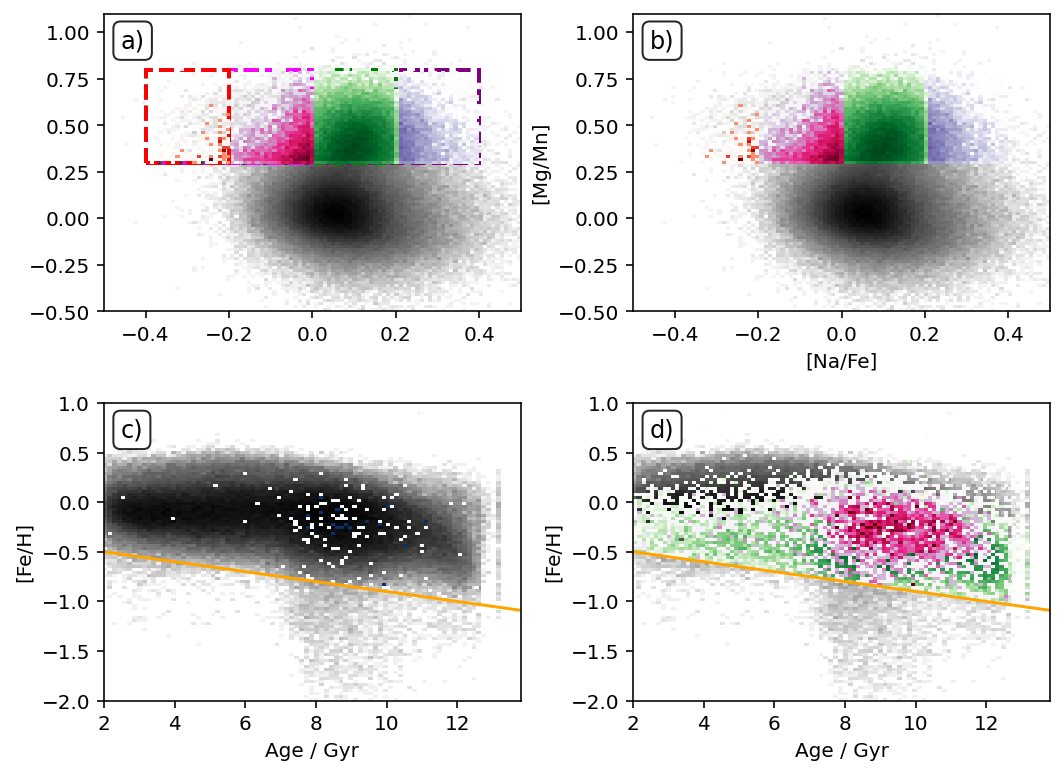

In [24]:
def plot_nafe_mgmn_dissection():

    f, gs = plt.subplots(2,2,figsize=(7.5,5.5))

    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,0]
    ax.text(0.04,0.95,'a)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    
    selection_na_fe = [-0.4,-0.2]
    selection_na_fe_2 = [-0.4, 0.0]
    selection_na_fe_3 = [-0.4, 0.2]
    selection_na_fe_4 = [-0.4, 0.4]
    selection_mg_mn = [0.3,0.8]
    
    selection_accreted = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe[0]) & 
        (obs['Na_fe'] < selection_na_fe[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )
    selection_accreted_2 = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe_2[0]) & 
        (obs['Na_fe'] < selection_na_fe_2[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )
    selection_accreted_3 = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe_3[0]) & 
        (obs['Na_fe'] < selection_na_fe_3[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )
    selection_accreted_4 = (
        observation_quality_check & 
        (obs['Na_fe'] > selection_na_fe_4[0]) & 
        (obs['Na_fe'] < selection_na_fe_4[1]) &
        (obs['Mg_fe'] - obs['Mn_fe'] > selection_mg_mn[0]) & 
        (obs['Mg_fe'] - obs['Mn_fe'] < selection_mg_mn[1]) & 
        (obs['fe_h'] > -0.4-0.05*obs['age_bstep'])
    )   


    polygon = Polygon(
        [
            [selection_na_fe[0],selection_mg_mn[0]],
            [selection_na_fe[0],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[1]],
            [selection_na_fe[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'r',
        ls = 'dashed',
        lw = 2
    )
    
    polygon_2 = Polygon(
        [
            [selection_na_fe_2[0],selection_mg_mn[0]],
            [selection_na_fe_2[0],selection_mg_mn[1]],
            [selection_na_fe_2[1],selection_mg_mn[1]],
            [selection_na_fe_2[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'magenta',
        ls = 'dashed',
        lw = 2
    )
    
    polygon_3 = Polygon(
        [
            [selection_na_fe_3[0],selection_mg_mn[0]],
            [selection_na_fe_3[0],selection_mg_mn[1]],
            [selection_na_fe_3[1],selection_mg_mn[1]],
            [selection_na_fe_3[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'g',
        ls = 'dashed',
        lw = 2
    )
    #ax.add_patch(polygon)

    polygon_4 = Polygon(
        [
            [selection_na_fe_4[0],selection_mg_mn[0]],
            [selection_na_fe_4[0],selection_mg_mn[1]],
            [selection_na_fe_4[1],selection_mg_mn[1]],
            [selection_na_fe_4[1],selection_mg_mn[0]],
        ], 
        True,
        fill=False,
        edgecolor = 'purple',
        ls = 'dashed',
        lw = 2
    )
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
    
    ax.add_patch(polygon_4) 
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_4],
        obs['Mg_fe'][selection_accreted_4] - obs['Mn_fe'][selection_accreted_4],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Purples',
        norm = LogNorm()
    )
    ax.add_patch(polygon_3) 
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_3],
        obs['Mg_fe'][selection_accreted_3] - obs['Mn_fe'][selection_accreted_3],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greens',
        norm = LogNorm()
    )
    ax.add_patch(polygon_2) 
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_2],
        obs['Mg_fe'][selection_accreted_2] - obs['Mn_fe'][selection_accreted_2],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='PuRd',
        norm = LogNorm()
    )
    ax.add_patch(polygon) 
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Reds',
        norm = LogNorm()
    )



#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')

    ax = gs[1,0]
    ax.text(0.04,0.95,'c)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Blues',
        norm = colors.LogNorm()
    );
#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')
    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )


    # [Na/Fe] vs. [Mg/Mn]
    ax = gs[0,1]
    ax.text(0.04,0.95,'b)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    observation_quality_check = (
        np.isfinite(obs['age_bstep']) &
        (obs['flag_sp'] == 0) & # quality for stellar parameters should be unflagged
        (obs['flag_fe_h'] == 0) & # [Fe/H] value should be an unflagged measurements
        (obs['age_bstep'] > 2) &
        (obs['e_age_bstep']/obs['age_bstep'] < 0.5) &
        np.all([[obs['e_'+element+'_fe'] < 0.2] for element in ['Na','Mg','Mn']],axis=0)[0] &
        np.all([[obs['flag_'+element+'_fe'] == 0] for element in ['Na','Mg','Mn']],axis=0)[0] & # flags for all abundances measurements should be unflagged, here only Mg is tested
        (obs['age_bstep'] > 2)
    )
    ax.set_xlabel('[Na/Fe]')
    ax.set_ylabel('[Mg/Mn]')
    
    p = ax.hist2d(
        obs['Na_fe'][observation_quality_check],
        obs['Mg_fe'][observation_quality_check] - obs['Mn_fe'][observation_quality_check],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greys',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')
        

    #ax.add_patch(polygon_4)   
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_4],
        obs['Mg_fe'][selection_accreted_4] - obs['Mn_fe'][selection_accreted_4],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Purples',
        norm = LogNorm()
    )
    #ax.add_patch(polygon_3)   
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_3],
        obs['Mg_fe'][selection_accreted_3] - obs['Mn_fe'][selection_accreted_3],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Greens',
        norm = LogNorm()
    )
    #ax.add_patch(polygon_2)   
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted_2],
        obs['Mg_fe'][selection_accreted_2] - obs['Mn_fe'][selection_accreted_2],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='PuRd',
        norm = LogNorm()
    )
    #ax.add_patch(polygon)   
    p = ax.hist2d(
        obs['Na_fe'][selection_accreted],
        obs['Mg_fe'][selection_accreted] - obs['Mn_fe'][selection_accreted],
        bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
        cmin = 1, cmap='Reds',
        norm = LogNorm()
    )
#     c = plt.colorbar(p[-1],ax=ax,extend='max')
#     c.set_label('Density')

    ax = gs[1,1]
    ax.text(0.04,0.95,'d)',transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][observation_quality_check],
        obs['fe_h'][observation_quality_check],
        bins = (np.linspace(0,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greys',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted_4],
        obs['fe_h'][selection_accreted_4],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Purples',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted_3],
        obs['fe_h'][selection_accreted_3],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Greens',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted_2],
        obs['fe_h'][selection_accreted_2],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='PuRd',
        norm = colors.LogNorm()
    );
    p, x, y, s = ax.hist2d(
        obs['age_bstep'][selection_accreted],
        obs['fe_h'][selection_accreted],
        bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
        cmin = 1,cmap='Reds',
        norm = colors.LogNorm()
    );
    
#     p = ax.hist2d(
#         obs['Na_fe'][selection_accreted_4],
#         obs['Mg_fe'][selection_accreted_4] - obs['Mn_fe'][selection_accreted_4],
#         bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
#         cmin = 1, cmap='Purples',
#         norm = LogNorm()
#     );    
#     p = ax.hist2d(
#         obs['Na_fe'][selection_accreted_3],
#         obs['Mg_fe'][selection_accreted_3] - obs['Mn_fe'][selection_accreted_3],
#         bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
#         cmin = 1, cmap='Greens',
#         norm = LogNorm()
#     );
#     p, x, y, s = ax.hist2d(
#         obs['age_bstep'][selection_accreted],
#         obs['fe_h'][selection_accreted],
#         bins = (np.linspace(2,13.8,100), np.linspace(-2,1,100)),
#         cmin = 1,cmap='Reds',
#         norm = colors.LogNorm()
#     );
#     p = ax.hist2d(
#         obs['Na_fe'][selection_accreted_2],
#         obs['Mg_fe'][selection_accreted_2] - obs['Mn_fe'][selection_accreted_2],
#         bins = (np.linspace(-0.5,0.5,100),np.linspace(-0.5,1.1,100)),
#         cmin = 1, cmap='PuRd',
#         norm = LogNorm()
#     );    

#     c = plt.colorbar(s,ax=ax,extend='max')
#     c.set_label('Density')
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax.plot(
        np.arange(0,15),
        -0.4-0.05*np.arange(0,15),
        c = 'orange'
    )
    
    plt.tight_layout()
    
    plt.savefig('figures/NaFe_MgMn_selection_Age_FeH_dissection.png',bbox_inches='tight',dpi=200)
    
plot_nafe_mgmn_dissection()

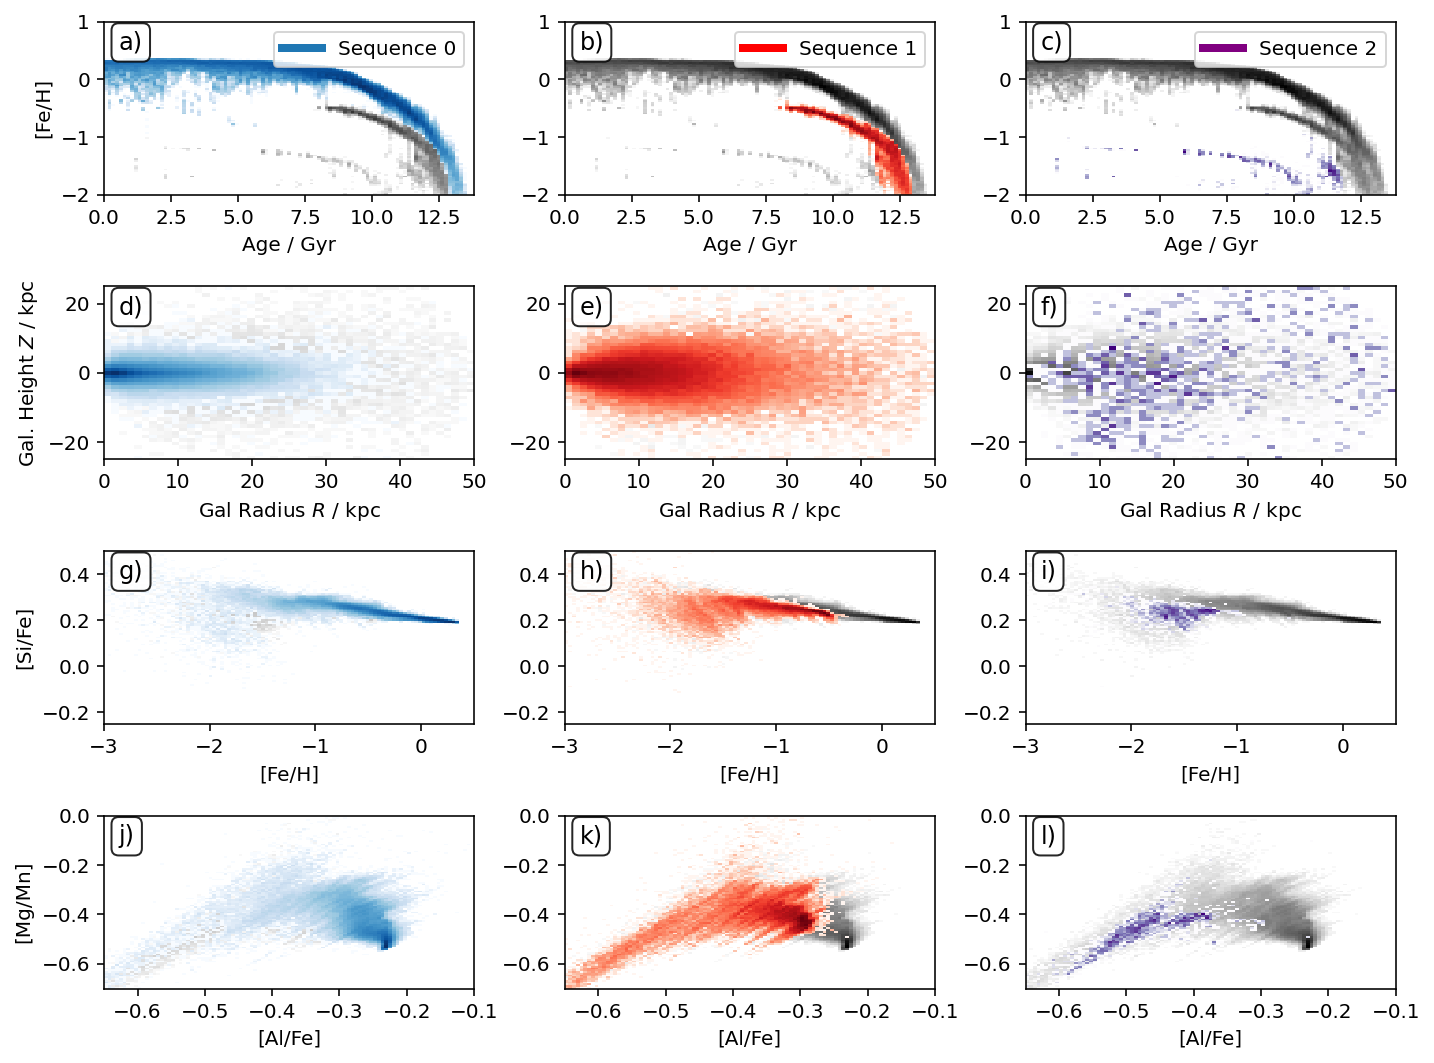

In [25]:
def plot_Alfe_mgmn_dissection_sim(save=False):

    f, gs = plt.subplots(4, 3,figsize=(10,7.5))

    selection_sequence1 = (
        (sim['Fe_H'] > -0.2) |
        ((sim['Fe_H'] > -1.) & (13.80-sim['tform'] < 7)) |
        (10**(sim['Fe_H']+0.2) > 1.9 - 0.15*(13.40-sim['tform']))
    )
    selection_sequence2 = (
        ~ selection_sequence1 &
        (sim['tform'] > 0.5) & 
        (sim['tform'] < 6) &
        (10**(sim['Fe_H']+0.3) > 1.8 - 0.15*(13.80-sim['tform']))
    )
    selection_sequence3 = (
        (~selection_sequence1) &
        (~selection_sequence2)
    )
    
    colors = ['C0','r','purple']
    cmaps = ['Blues','Reds','Purples']
    
    for index, selection in enumerate([selection_sequence1,selection_sequence2,selection_sequence3]):

        # Age-Metallicity-Relation

        x_bins = np.linspace(0,13.8,100)
        y_bins = np.linspace(-2,1,100)

        panels = ['a)','b)','c)']
        
        ax = gs[0,index]
        ax.set_xlabel('Age / Gyr')
        if index == 0:
            ax.set_ylabel('[Fe/H]')
        ax.text(0.04,0.95,panels[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

        p, x, y, s = ax.hist2d(
            # Ensuring plots are over age, and consistent with b_age_step
            13.8 - sim['tform'],
            sim['Fe_H'],
            bins = (x_bins, y_bins),
            cmin = 1,cmap='Greys',
            norm = LogNorm()
        );
        p, x, y, s = ax.hist2d(
            # Ensuring plots are over age, and consistent with b_age_step
            13.8 - sim['tform'][selection],
            sim['Fe_H'][selection],
            bins = (x_bins, y_bins),
            cmin = 1,cmap=cmaps[index],
            norm = LogNorm()
        );
        legend_elements = [
            Line2D([0], [0], color=colors[index], lw=4, label='Sequence '+str(index))
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        
        panels = ['d)','e)','f)']
        
        x_bins = np.linspace(0,50,50)
        y_bins = np.linspace(-25,25,50)


        X = np.sqrt(sim['x']**2+sim['y']**2)
        Y = sim['z']
        
        ax = gs[1,index]
        ax.text(0.04,0.95,panels[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel('Gal Radius $R$ / kpc')
        if index == 0:
            ax.set_ylabel('Gal. Height $Z$ / kpc')
            
        p = ax.hist2d(
            X,
            Y,
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys',
            norm = LogNorm()
        )
        p = ax.hist2d(
            X[selection],
            Y[selection],
            bins=(x_bins,y_bins),
            cmin=1,cmap=cmaps[index],
            norm=LogNorm()
        )

        # [Fe/H] vs. [Si/Fe]
        
        x_bins = np.linspace(-3,0.5,100)
        y_bins = np.linspace(-0.25,0.5,100)

        panels = ['g)','h)','i)']
        
        ax = gs[2,index]
        ax.text(0.04,0.95,panels[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel('[Fe/H]')
        if index == 0:
            ax.set_ylabel('[Si/Fe]')

        p = ax.hist2d(
            sim['Fe_H'],
            sim['Si_H'] - sim['Fe_H'],
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys',
            norm = LogNorm()
        )
        p = ax.hist2d(
            sim['Fe_H'][selection],
            sim['Si_H'][selection] - sim['Fe_H'][selection],
            bins = (x_bins, y_bins),
            cmin = 1, cmap=cmaps[index],
            norm = LogNorm()
        )
        # [Al/Fe] vs. [Mg/Mn]

        x_bins = np.linspace(-0.65,-0.1,100)
        y_bins = np.linspace(-0.7,0,100)

        panels = ['j)','k)','l)']
        
        ax = gs[3,index]
        ax.text(0.04,0.95,panels[index],transform=ax.transAxes,fontsize=12,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
        ax.set_xlabel('[Al/Fe]')
        if index == 0:
            ax.set_ylabel('[Mg/Mn]')

        p = ax.hist2d(
            sim['Al_H'] - sim['Fe_H'],
            sim['Mg_H'] - sim['Mn_H'],
            bins = (x_bins, y_bins),
            cmin = 1, cmap='Greys',
            norm = LogNorm()
        )
        p = ax.hist2d(
            sim['Al_H'][selection] - sim['Fe_H'][selection],
            sim['Mg_H'][selection] - sim['Mn_H'][selection],
            bins = (x_bins, y_bins),
            cmin = 1, cmap=cmaps[index],
            norm = LogNorm()
        )
    

    plt.tight_layout()
    
    if save:
        plt.savefig('figures/AlFe_MgMn_selection_Age_FeH_dissection_sim.png',bbox_inches='tight',dpi=200)
    
plot_Alfe_mgmn_dissection_sim()

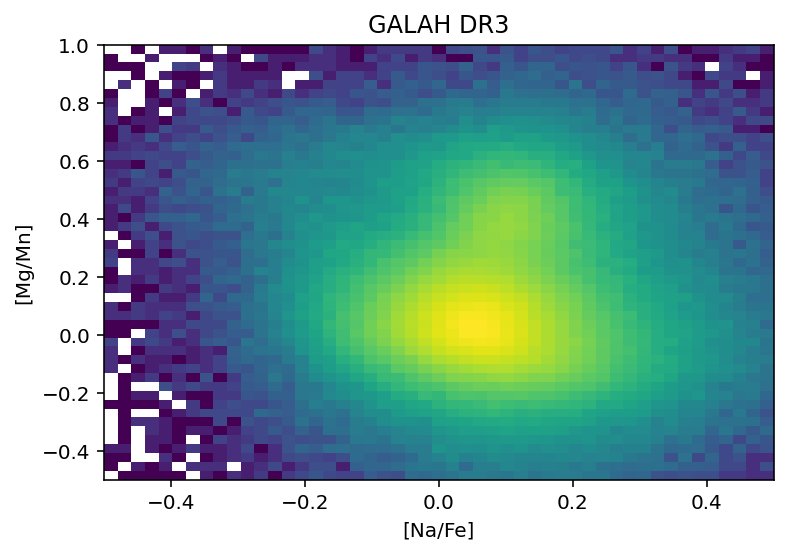

In [26]:
p, x, y, s = plt.hist2d(
    obs['Na_fe'],
    obs['Mg_fe']-obs['Mn_fe'],
    bins = (np.linspace(-0.5, 0.5, 50), np.linspace(-0.5, 1, 50)),
    cmin = 1,
    norm = colors.LogNorm()
);
c = plt.colorbar(s, ax=ax)
c.set_label('Nr')
plt.xlabel('[Na/Fe]')
plt.ylabel('[Mg/Mn]')
plt.title('GALAH DR3')
s.set_cmap('viridis')
# ax.axvline(0, color='grey')
# ax.axhline(0, color = 'grey')


# Spatial distribution

In [27]:
def hist2d_bin_colored(X,Y,Z,X_label='X\_label',Y_label='Y\_label',Z_label='Z\_label',bins=30,bin_function='median',ax=None,cmap='seismic_r',minimum_bin_entries = 5,colorbar_orientation='vertical',**kwargs):
    """
    INPUT:
    X : x-axis parameter
    Y : y-axis parameter
    Z : parameter that will be used for coloring the bins
    X/Y/Z_label : label names
    bins = 30, but you can also give it bins = (np.linspace(x_min,x_max,30),np.linspace(y_min,y_max,30))
    bin_function : median/average/sum
    ax : if you plot it as part of an f,ax = plt.subplots()
    minimum_bin_entries : how many entries do we expect, before we even consider throwing some fancy function at them
    
    OUTPUT:
    plt.imshow
    """
    
    # First make sure we only work with finite values
    finite = np.isfinite(X) & np.isfinite(Y) & np.isfinite(Z)
    if len(X[finite])!=len(X):
        print('Not all values were finite! Continuing with only finite ones')
    X=X[finite];Y=Y[finite];Z=Z[finite]
    
    # Now create the matrix of bins and its bin-edges
    H,xedges,yedges = np.histogram2d(X,Y,bins=bins)

    # Create the matrix that we want to store color-values in
    color_matrix = np.zeros_like(H)
    color_matrix[:] = np.nan
    
    # Loop through the x- and y-bins
    for x_bin in range(len(xedges)-1):
        for y_bin in range(len(yedges)-1):
            in_xy_bin = (X>=xedges[x_bin])&(X<xedges[x_bin+1])&(Y>=yedges[y_bin])&(Y<yedges[y_bin+1])
            
            # We only add a value if there are more than *minimum_bin_entries* in the bin
            if len(Z[in_xy_bin]) >= minimum_bin_entries:
                if bin_function=='median':
                    color_matrix[x_bin,y_bin]=np.median(Z[in_xy_bin])
                elif bin_function=='average':
                    color_matrix[x_bin,y_bin]=np.average(Z[in_xy_bin])
                elif bin_function=='sum':
                    color_matrix[x_bin,y_bin]=np.sum(Z[in_xy_bin])
                elif bin_function=='std':
                    color_matrix[x_bin,y_bin]=np.std(Z[in_xy_bin])
                else:
                    raise NameError('Only bin_function = median/average/sum available')

    # Create an axis if not given
    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
    if X_label != None:
        ax.set_xlabel(X_label)
    if Y_label != None:
        ax.set_ylabel(Y_label)

    # Populate the keyword arguments for the imshow
    imshow_kwargs = dict(
        cmap = cmap,aspect='auto',origin='lower'
    )
    # Update by any arguments given through **kwargs
    imshow_kwargs.update(kwargs)

    # Plot!
    s = ax.imshow(color_matrix.T,extent=(xedges[0],xedges[-1],yedges[0],yedges[-1]),**imshow_kwargs)
    c = plt.colorbar(s, ax=ax, orientation=colorbar_orientation)
    if Z_label != None:
        c.set_label(Z_label)

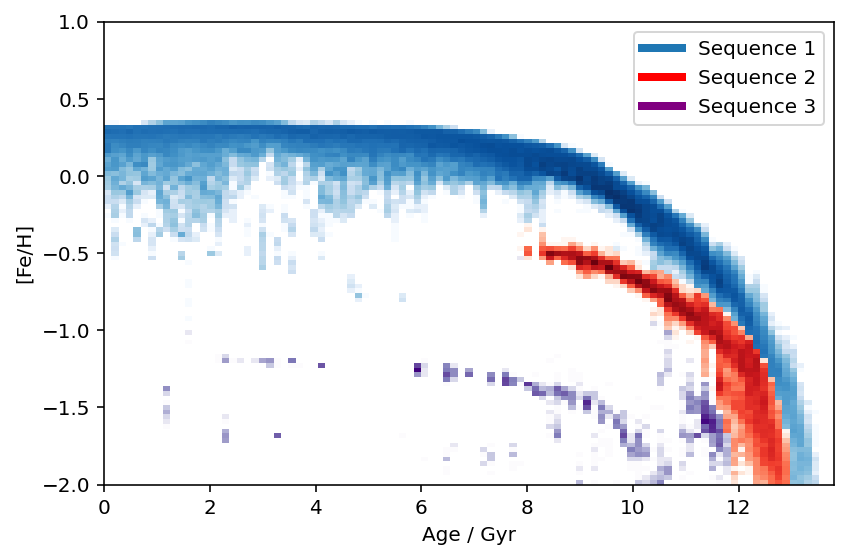

In [28]:
x_bins = np.linspace(0,13.8,100)
y_bins = np.linspace(-2,1,100)

selection_sequence1 = (
    (sim['Fe_H'] > -0.2) |
    ((sim['Fe_H'] > -1.) & (13.80-sim['tform'] < 7)) |
    (10**(sim['Fe_H']+0.2) > 1.9 - 0.15*(13.40-sim['tform']))
)
selection_sequence2 = (
    ~ selection_sequence1 &
    (sim['tform'] > 0.5) & 
    (sim['tform'] < 6) &
    (10**(sim['Fe_H']+0.3) > 1.8 - 0.15*(13.80-sim['tform']))
)
selection_sequence3 = (
    (~selection_sequence1) &
    (~selection_sequence2)
)

f, ax = plt.subplots()
p, x, y, s = ax.hist2d(
    # Ensuring plots are over age, and consistent with b_age_step
    13.8 - sim['tform'],
    sim['Fe_H'],
    bins = (x_bins, y_bins),
    cmin = 1,cmap='Greys',
    norm = colors.LogNorm()
);
p, x, y, s = ax.hist2d(
    # Ensuring plots are over age, and consistent with b_age_step
    13.8 - sim['tform'][selection_sequence1],
    sim['Fe_H'][selection_sequence1],
    bins = (x_bins, y_bins),
    cmin = 1,cmap='Blues',
    norm = colors.LogNorm()
);
p, x, y, s = ax.hist2d(
    # Ensuring plots are over age, and consistent with b_age_step
    13.8 - sim['tform'][selection_sequence2],
    (sim['Fe_H'][selection_sequence2]),
    bins = (x_bins, y_bins),
    cmin = 1,cmap='Reds',label='Group 2',
    norm = colors.LogNorm()
);
p, x, y, s = ax.hist2d(
    # Ensuring plots are over age, and consistent with b_age_step
    13.8 - sim['tform'][selection_sequence3],
    (sim['Fe_H'][selection_sequence3]),
    bins = (x_bins, y_bins),
    cmin = 1,cmap='Purples',
    norm = colors.LogNorm()
);

ax.set_xlabel('Age / Gyr')
ax.set_ylabel('[Fe/H]')

legend_elements = [
    Line2D([0], [0], color='C0', lw=4, label='Sequence 1'),
    Line2D([0], [0], color='r', lw=4, label='Sequence 2'),
    Line2D([0], [0], color='purple', lw=4, label='Sequence 3')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()

plt.savefig('figures/sequences_in_age_feh.png',bbox_inches='tight',dpi=200)

In [29]:
#sim['R'] = np.sqrt(sim['x']**2+sim['y']**2)
R = np.sqrt(sim['x']**2+sim['y']**2)

Text(0, 0.5, 'z / kpc')

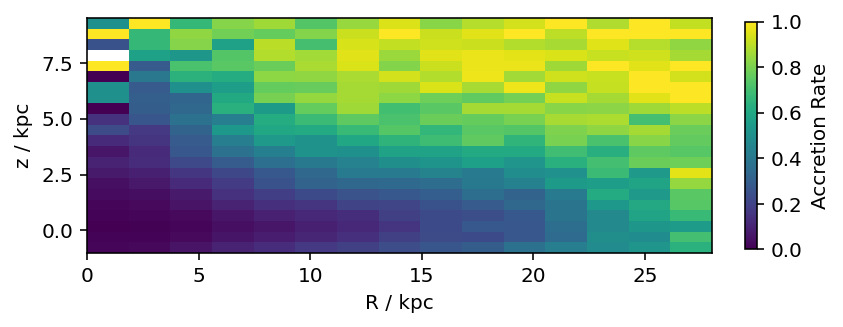

In [30]:
# Replicating Martig et al 
R_bin_size = 2 # kpc
z_bin_size = 0.5 # kpc

R_bins = np.arange(0,30,R_bin_size)
z_bins = np.arange(-1,10,z_bin_size)

accretion_rate = np.ones((len(R_bins),len(z_bins)))

for R_index,R_bin in enumerate(R_bins):
    for z_index,z_bin in enumerate(z_bins):
        nr_in_bins = len(np.where((
            (R > R_bin-0.5*R_bin_size) & (R < R_bin+0.5*R_bin_size) & 
            (sim['z'] > z_bin-0.5*z_bin_size) & (sim['z'] < z_bin+0.5*z_bin_size)
        ) == True)[0])
        
        nr_in_bins_and_accreted = len(np.where((
            (R > R_bin-0.5*R_bin_size) & (R < R_bin+0.5*R_bin_size) & 
            (sim['z'] > z_bin-0.5*z_bin_size) & (sim['z'] < z_bin+0.5*z_bin_size) &
            (
                #selection_sequence1 &
                selection_sequence2 |
                selection_sequence3
#                 (sim['Fe_H'] < -0.4) &
#                 (sim['Fe_H'] < 0.3*sim['tform']-1.55) &
#                 (sim['Fe_H'] < 0.6*sim['tform']-2.1)
            )
        ) == True)[0])
        try:
            accretion_rate[R_index,len(z_bins)-z_index-1] = nr_in_bins_and_accreted / nr_in_bins
        except:
            accretion_rate[R_index,len(z_bins)-z_index-1] = np.NaN

s = plt.imshow(accretion_rate.T,extent=(R_bins[0],R_bins[-1],z_bins[0],z_bins[-1]), aspect=1)
c = plt.colorbar(s, fraction=0.017)
c.set_label('Accretion Rate')
plt.xlabel('R / kpc')
plt.ylabel('z / kpc')

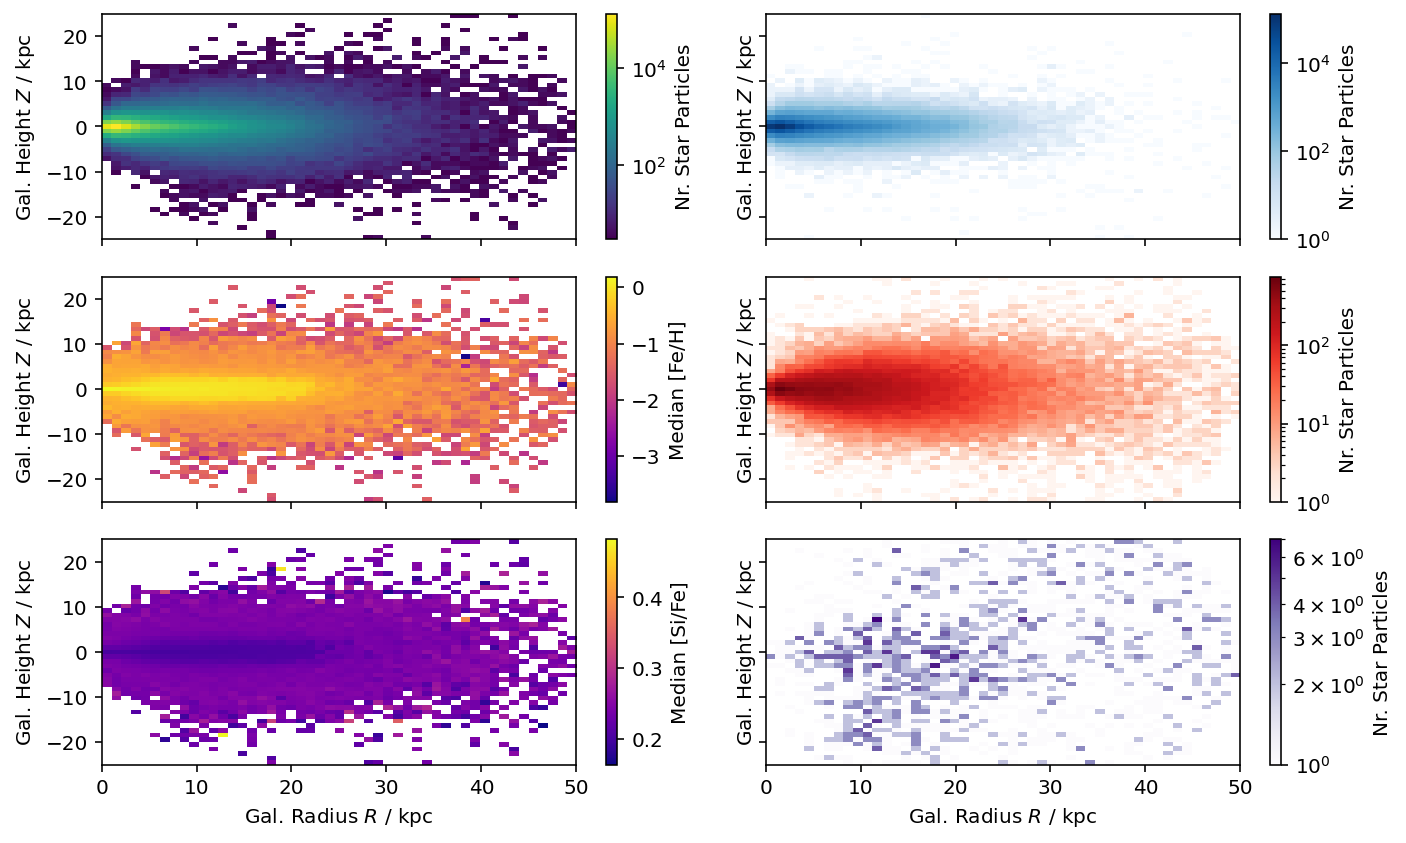

In [31]:
### NOT USED IN PAPER
f, gs = plt.subplots(3,2,figsize=(10,6),sharex=True,sharey=True)

x_bins = np.linspace(0,50,50)
y_bins = np.linspace(-25,25,50)


X = np.sqrt(sim['x']**2+sim['y']**2)
Y = sim['z']

ax=gs[0,0]
p = ax.hist2d(
    X,
    Y,
    bins=(x_bins,y_bins),
    cmin=3,
    norm=LogNorm()
);
ax.set_ylabel('Gal. Height $Z$ / kpc')
c = plt.colorbar(p[-1],ax=ax)
c.set_label('Nr. Star Particles')

ax=gs[1,0]
hist2d_bin_colored(
    X,
    Y,
    Z = sim['Fe_H'],
    X_label=None,Y_label='Gal. Height $Z$ / kpc',Z_label='Median [Fe/H]',
    bins=(x_bins,y_bins),
    bin_function='median',
    ax=ax,
    cmap='plasma',
    minimum_bin_entries = 3
)

ax=gs[2,0]
hist2d_bin_colored(
    X,
    Y,
    Z = sim['Si_H'] - sim['Fe_H'],
    X_label='Gal. Radius $R$ / kpc',Y_label='Gal. Height $Z$ / kpc',Z_label='Median [Si/Fe]',
    bins=(x_bins,y_bins),
    bin_function='median',
    ax=ax,
    cmap='plasma',
    minimum_bin_entries = 3
)

ax=gs[0,1]
p = ax.hist2d(
    X[selection_sequence1],
    Y[selection_sequence1],
    bins=(x_bins,y_bins),
    cmin=1,cmap='Blues',
    norm=LogNorm()
);
ax.set_ylabel('Gal. Height $Z$ / kpc')
c = plt.colorbar(p[-1],ax=ax)
c.set_label('Nr. Star Particles')
ax=gs[1,1]
p = ax.hist2d(
    X[selection_sequence2],
    Y[selection_sequence2],
    bins=(x_bins,y_bins),
    cmin=1,cmap='Reds',
    norm=LogNorm()
);
ax.set_ylabel('Gal. Height $Z$ / kpc')
c = plt.colorbar(p[-1],ax=ax)
c.set_label('Nr. Star Particles')
ax=gs[2,1]
p = ax.hist2d(
    X[selection_sequence3],
    Y[selection_sequence3],
    bins=(x_bins,y_bins),
    cmin=1,cmap='Purples',
    norm=LogNorm()
);
ax.set_xlabel('Gal. Radius $R$ / kpc')
ax.set_ylabel('Gal. Height $Z$ / kpc')
c = plt.colorbar(p[-1],ax=ax)
c.set_label('Nr. Star Particles')

plt.tight_layout()

plt.savefig('figures/sequences_in_space.png',bbox_inches='tight',dpi=200)

In [32]:
# Here we convert the cartesian coordinates into cylindrical
r = np.sqrt(sim['x']**2+sim['y']**2)
phi = np.arctan(sim['y']/sim['x'])
phi[sim['x'] < 0] += np.pi # this is needed to have a smooth behavior in phi
z = sim['z']

vr = sim['vx'] * np.cos(phi) + sim['vy'] * np.sin(phi)
vphi = -sim['vx'] * np.sin(phi) + sim['vy'] * np.cos(phi)
vz = sim['vz']

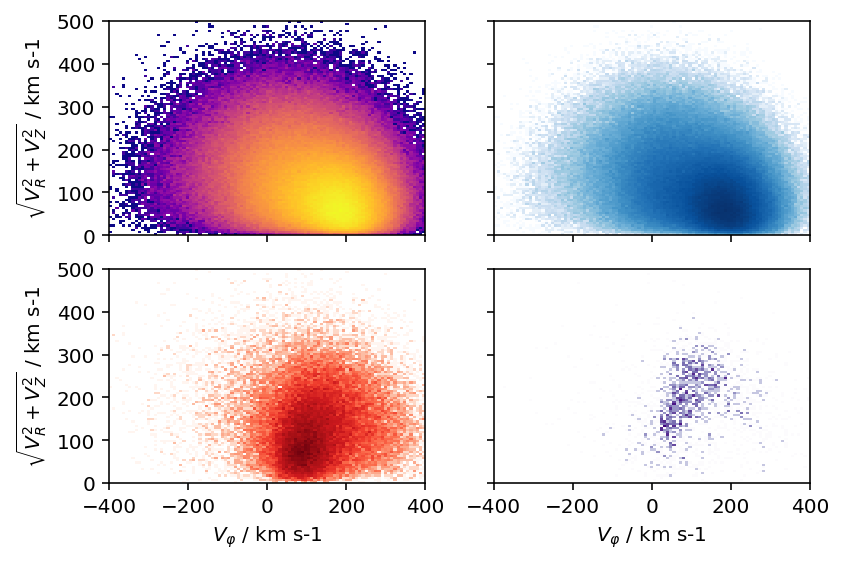

In [33]:
### NOT USED IN PAPER
f, gs = plt.subplots(2,2,sharex=True,sharey=True)

bins = (np.linspace(-400,400,100),np.linspace(0,500,100))
ax = gs[0,0]
ax.hist2d(
    vphi,
    np.sqrt(vr**2+vz**2),
    bins=bins,cmin=1,norm=LogNorm(),cmap='plasma'
);
ax.set_ylabel(r'$\sqrt{V_R^2 + V_Z^2}$ / km s-1')

ax = gs[0,1]
ax.hist2d(
    vphi[selection_sequence1],
    np.sqrt(vr[selection_sequence1]**2+vz[selection_sequence1]**2),
    bins=bins,cmin=1,norm=LogNorm(),cmap='Blues'
);
ax = gs[1,0]
ax.hist2d(
    vphi[selection_sequence2],
    np.sqrt(vr[selection_sequence2]**2+vz[selection_sequence2]**2),
    bins=bins,cmin=1,norm=LogNorm(),cmap='Reds'
);
ax.set_xlabel(r'$V_\varphi$ / km s-1')
ax.set_ylabel(r'$\sqrt{V_R^2 + V_Z^2}$ / km s-1')

ax = gs[1,1]
ax.hist2d(
    vphi[selection_sequence3],
    np.sqrt(vr[selection_sequence3]**2+vz[selection_sequence3]**2),
    bins=bins,cmin=1,norm=LogNorm(),cmap='Purples'
);
ax.set_xlabel(r'$V_\varphi$ / km s-1')
plt.tight_layout()
plt.savefig('figures/sequences_in_toomre.png',dpi=200,bbox_inches='tight')